# Healthcare Provider Fraud Detection Analysis

## 1.Business Problem:

## 1.1. What is healthcare fraud?

Health insurance companies provide coverage for medical expenses to the policy holder depending on the health insurance plan chosen by the patient which the patient is eligible to claim.These amounts may vary depending upon diagnosis and treatement done on the patient and depending upon doctor and hospital.Many healthcare providers settle huge amounts for patients. But some insured individuals or the provider of health services attempt to make fake claims by giving false claim details which is considered a medical crime 

## 1.2. Problem Statement

Insurance companies are forced to provide benefits for fake claims unknowingly and face many problems in providing benefits to real claims and also those companies are heavily impacted due these bad practices. This has become a serious issue and insurance providers have started finding ways to detect whether the claim is fraud or not. The goal of this case study is to <b>accurately predict claims into fraudulent or real claims</b> which will save a very huge amount of money from frauds and help those in real need.

## 1.3. Datasource Link

https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis 
This dataset is taken from kaggle.

## 1.4. Business objectives and constraints

1. Rate of misclassification should be very less
2. No low latency requirement

## 2. Mapping to Machine Learning Problem

### 2.1. Type of ML problem

This is a binary classification problem. We need to classify datapoint into fraudulent or real claim

### 2.2. Performance Metric

1. f1 score
2. macro f1 score ( as there is slight imbalance of class 64:36 , using macro will be useful. it give equal importance to both      class )
3. Accuracy

## Deployment of model in heroku
https://healthcare-prediction.herokuapp.com/

### Importing important packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 
import seaborn as sns
%matplotlib inline
from collections import Counter 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score, confusion_matrix
from prettytable import PrettyTable
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# loading csv file

train_outpatient = pd.read_csv('Train_Outpatientdata.csv')
train_inpatient = pd.read_csv('Train_Inpatientdata.csv')
train_beneficiary = pd.read_csv('Train_Beneficiarydata.csv')
print('train_outpatient shape: ',train_outpatient.shape)
print('train_inpatient shape: ',train_inpatient.shape)
print('train_beneficiary shape: ',train_beneficiary.shape)

train_outpatient shape:  (477187, 27)
train_inpatient shape:  (40474, 30)
train_beneficiary shape:  (138556, 25)


In [4]:
# loading target train file

train_target = pd.read_csv('Train.csv')
print('train_target shape: ',train_target.shape)

train_target shape:  (5410, 2)


In [5]:
print('train_outpatient columns are : ',train_outpatient.columns.values)
print(' '*100)
print('-'*100)
print(' '*100)
print('train_inpatient columns are : ',train_inpatient.columns.values)
print(' '*100)
print('-'*100)
print(' '*100)
print('train_beneficiary columns are : ',train_beneficiary.columns.values)

train_outpatient columns are :  ['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2'
 'ClmDiagnosisCode_3' 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5'
 'ClmDiagnosisCode_6' 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8'
 'ClmDiagnosisCode_9' 'ClmDiagnosisCode_10' 'ClmProcedureCode_1'
 'ClmProcedureCode_2' 'ClmProcedureCode_3' 'ClmProcedureCode_4'
 'ClmProcedureCode_5' 'ClmProcedureCode_6' 'DeductibleAmtPaid'
 'ClmAdmitDiagnosisCode']
                                                                                                    
----------------------------------------------------------------------------------------------------
                                                                                                    
train_inpatient columns are :  ['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysic

#### merging train_inpatient, train_outpatient data

In [6]:
## https://www.kaggle.com/dimagmehanic/mc-termpaper
## merging df without repeting same columns
## left_on and right_on use that columns as keys to merge.
## left_on will take columns from left dataframe and right_on will take columns from right dataframe as keys.
## so columns with same name will be used as keys ( so repeting of columns will be avoided ) and remaining columns will be merged. inpatient - 30 columns, outpatient - 27 columns. merged df shape will be with 30 columns

final_data = pd.merge(train_inpatient, train_outpatient, left_on = [ col for col in train_outpatient.columns if col in train_inpatient.columns], \
                    right_on = [ col for col in train_outpatient.columns if col in train_inpatient.columns], how = 'outer')
final_data.shape

(517661, 30)

In [7]:
final_data.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


#### merging final_data, train_beneficiary data

In [8]:
final_data = pd.merge(final_data,train_beneficiary,how='inner',on='BeneID' )

In [9]:
final_data.shape

(517661, 54)

#### merging final_data, train_target data 

In [10]:
final_data = pd.merge(final_data,train_target,how='outer',on='Provider')

In [11]:
final_data.shape

(517679, 55)

In [12]:
final_data.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCon

In [13]:
final_data.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,NaN,NaN,2009-04-12,...,1.0,1.0,2.0,1.0,1.0,36000.0,3204.0,60.0,70.0,Yes
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50.0,PHY365867,PHY327147,NaN,NaN,...,2.0,1.0,2.0,2.0,2.0,24000.0,2136.0,450.0,200.0,Yes
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000.0,PHY349293,PHY370861,PHY363291,2009-01-20,...,2.0,1.0,2.0,2.0,2.0,19000.0,1068.0,100.0,20.0,Yes
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000.0,PHY334706,PHY334706,NaN,2009-10-17,...,2.0,1.0,1.0,2.0,2.0,17000.0,1068.0,1050.0,540.0,Yes
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000.0,PHY390614,PHY323689,PHY363291,2009-10-25,...,1.0,1.0,1.0,1.0,2.0,27000.0,2136.0,450.0,160.0,Yes


In [14]:
final_data = final_data.iloc[:50000, :]

In [15]:
final_data.shape

(50000, 55)

## 3. Exploratory Data Analysis

## 3.1. Percentage of class label

### PotentialFraud class distribution in outpatient data  using bar plot

In [16]:
## merging train_outpatient, train_target

train_outpatient = pd.merge(train_outpatient,train_target,how='outer',on='Provider')


## number of points in fraud ('yes') and non-fraud (no) class

train_outpatient['PotentialFraud'].value_counts()

No     302813
Yes    174790
Name: PotentialFraud, dtype: int64

percentage of fraud class :  36.597341306482576
percentage of non fraud class :  63.402658693517424


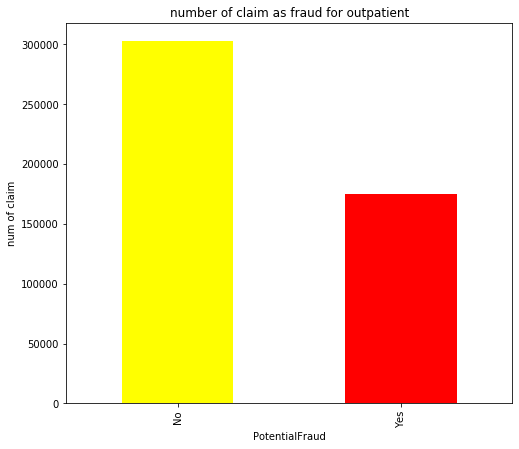

In [17]:
class_count = train_outpatient['PotentialFraud'].value_counts().to_frame()

""" calculating percentage of yes and no class  """

percentage_yes = (class_count['PotentialFraud']['Yes']/(class_count['PotentialFraud']['Yes']+class_count['PotentialFraud']['No']))*100
print('percentage of fraud class : ',percentage_yes)
percentage_no = (class_count['PotentialFraud']['No']/(class_count['PotentialFraud']['Yes']+class_count['PotentialFraud']['No']))*100
print('percentage of non fraud class : ',percentage_no)

train_outpatient['PotentialFraud'].value_counts().plot(kind='bar',color=('yellow','red'),title='number of claim as fraud for outpatient',figsize=(8,7))
plt.xlabel('PotentialFraud')
plt.ylabel('num of claim')
plt.show()


### conclusion
1. In train outpatient file there are 328697 non fraud, 189438 fraud claim
2. percentage of yes class is 36.5615138912, no class is 63.4384861088
3. this show most of outpatient claim is non fraud
4. this can be reason because people are more concentrated on doing fraud claim for inpatient 



### PotentialFraud class distribution in inpatient data using bar plot

In [18]:
## merging train_inpatient, train_target

train_inpatient = pd.merge(train_inpatient,train_target,how='outer',on='Provider')

## number of points in fraud ('yes') and non-fraud (no) class

train_inpatient['PotentialFraud'].value_counts()

Yes    23468
No     20324
Name: PotentialFraud, dtype: int64

percentage of fraud class :  53.58969674826453
percentage of non fraud class :  46.41030325173547


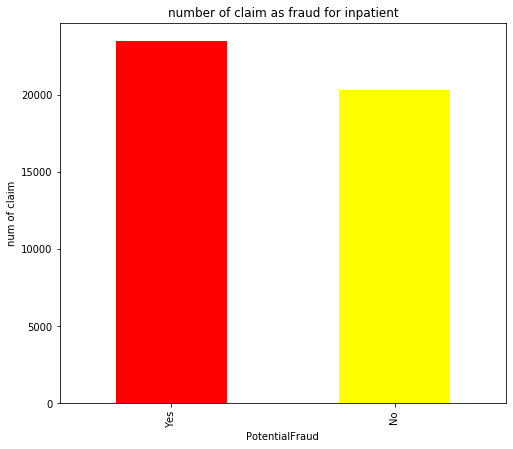

In [19]:
class_count = train_inpatient['PotentialFraud'].value_counts().to_frame()

""" calculating percentage of yes and no class  """

percentage_yes = (class_count['PotentialFraud']['Yes']/(class_count['PotentialFraud']['Yes']+class_count['PotentialFraud']['No']))*100
print('percentage of fraud class : ',percentage_yes)
percentage_no = (class_count['PotentialFraud']['No']/(class_count['PotentialFraud']['Yes']+class_count['PotentialFraud']['No']))*100
print('percentage of non fraud class : ',percentage_no)

train_inpatient['PotentialFraud'].value_counts().plot(kind='bar',color=('red','yellow'),title='number of claim as fraud for inpatient',figsize=(8,7))
plt.xlabel('PotentialFraud')
plt.ylabel('num of claim')
plt.show()


### conclusion
1. In train inpatient file there are 20324 non fraud, 23468 fraud claim
2. percentage of yes class is 53.5896967483, no class is 46.4103032517
3. this show people are more concentrated on doing fraud claim for inpatient because more amount can be claimed for inpatient



## 3.2. AttendingPhysician feature 

### 3.2.1.Univariate analysis -  Analysing AttendingPhysician feature with bar plot for outpatient

In [20]:
def count_(data,column,ylabel,title):
    """ calculating num of cases attended by physician and plotting vs fraud """
    
    ## counting number of cases for each physician and saving in dict
    
    count = data[column].value_counts().to_dict()
    
    col = str(column)+'count'           ## giving column name to be added
   
    ## making new column for number of cases for each physician as 'AttendingPhysiciancount' by mapping count dict to train_outpatient['AttendingPhysician'] 

    data[col]=data[column].map(count)
    
    ## top 5 attended physician
    count = data[column].value_counts()[0:5]
    print('top 5',column,'are: ',count)
    
    ## plot 
    sns.boxplot(x='PotentialFraud',y=col, data=data)
    plt.xlabel('potential fraud')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


top 5 AttendingPhysician are:  PHY330576    2340
PHY350277    1492
PHY412132    1196
PHY423534    1145
PHY314027    1117
Name: AttendingPhysician, dtype: int64


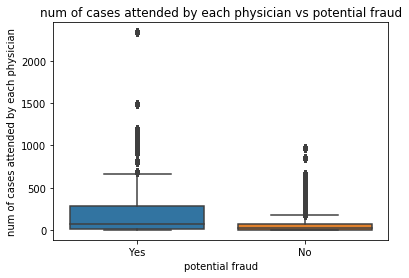

In [21]:
count_(train_outpatient,'AttendingPhysician','num of cases attended by each physician','num of cases attended by each physician vs potential fraud')

### conclusion 

1. The most attended physician is PHY330576 attending 2534 cases.
2. If a physician has attended more number of case, then the physician involved in making fraud claim is more
3. The top 5 attended physician are PHY330576,PHY350277,PHY412132,PHY423534,PHY314027
4. The top attended physician's make more fraud claim
5. The physician who attended only very few cases make non fraud claim


### 3.2.2. Univariate analysis - Analysing AttendingPhysician feature with bar plot for inpatient

top 5 AttendingPhysician are:  PHY422134    386
PHY341560    274
PHY315112    208
PHY411541    198
PHY362864    195
Name: AttendingPhysician, dtype: int64


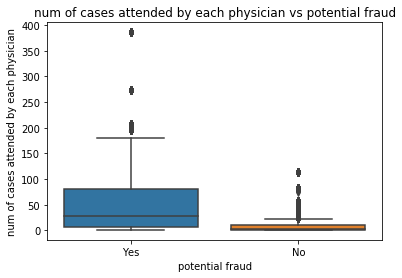

In [22]:
count_(train_inpatient,'AttendingPhysician','num of cases attended by each physician','num of cases attended by each physician vs potential fraud')

### conclusion 

1. The most attended physician is PHY422134 attending 386 cases.
2. If a physician has attended more number of case, then the physician involved in making fraud claim is more
3. The top 5 attended physician are PHY422134,PHY341560,PHY315112,PHY411541,PHY362864
4. The top attended physician's make more fraud claim
5. The physician who attended only very few cases make non fraud claim


## 3.3. Provider feature

### 3.3.1. Univariate analysis - Analysing Provider feature with bar plot for outpatient

top 5 Provider are:  PRV51459    7654
PRV53797    4294
PRV51574    4108
PRV53918    3317
PRV54895    3155
Name: Provider, dtype: int64


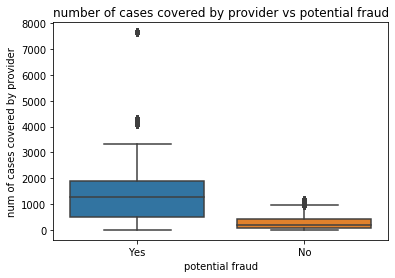

In [23]:
count_(train_outpatient,'Provider','num of cases covered by provider','number of cases covered by provider vs potential fraud')

In [24]:
""" function to calculate number of yes and no class present for provider """
def count_provider(provider):
    yes=0
    no=0
    for i in range(len(train_inpatient)):  ## use len(train_outpatient) for outpatient provider 
        count=''
        if train_inpatient['Provider'][i] == provider:
            count = count+train_inpatient['PotentialFraud'][i]
            if count=='Yes':
                yes=yes+1
            else:
                no=no+1
    return yes,no

In [25]:
## checking class present for top provider

print('top 1 provider has classes (yes,no) : ',count_provider('PRV51459'))
print('top 2 provider has classes (yes,no) : ',count_provider('PRV53797'))
print('top 93rd provider has classes (yes,no) : ',count_provider('PRV51393'))
print('top 94th provider has classes (yes,no) : ',count_provider('PRV54690'))



top 1 provider has classes (yes,no) :  (1, 0)
top 2 provider has classes (yes,no) :  (1, 0)
top 93rd provider has classes (yes,no) :  (68, 0)
top 94th provider has classes (yes,no) :  (0, 1)


### conclusion 

1. The top provider is PRV51459 with 8240 cases
2. here provider those made non fraud claim give coverage for only few cases 
3. provider that made coverage for many cases show more fraud claim made
4. The top 5 attended provider are PRV51459,PRV53797,PRV51574,PRV53918,PRV54895
5. top 93 provider has made fraud claim , indicating top provider have more probabilty for making fraud claim



### 3.3.2. Univariate analysis - Analysing Provider feature with bar plot for inpatient

top 5 Provider are:  PRV52019    516
PRV55462    386
PRV54367    322
PRV53706    282
PRV55209    275
Name: Provider, dtype: int64


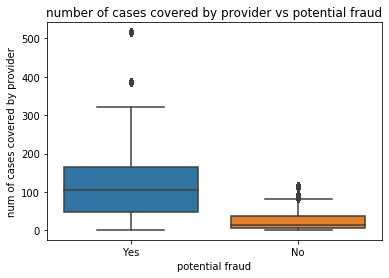

In [26]:
count_(train_inpatient,'Provider','num of cases covered by provider','number of cases covered by provider vs potential fraud')

In [27]:
## checking class present for top provider

print('top 1 provider has classes (yes,no) : ',count_provider('PRV52019'))
print('top 2 provider has classes (yes,no) : ',count_provider('PRV55462'))
print('top 83rd provider has classes (yes,no) : ',count_provider('PRV51542'))
print('top 84th provider has classes (yes,no) : ',count_provider('PRV55978'))



top 1 provider has classes (yes,no) :  (516, 0)
top 2 provider has classes (yes,no) :  (386, 0)
top 83rd provider has classes (yes,no) :  (93, 0)
top 84th provider has classes (yes,no) :  (0, 92)


### conclusion 

1. The top provider is PRV52019 with 516 cases
2. here provider those made non fraud claim give coverage for only few cases 
3. provider that made coverage for many cases show more fraud claim made
4. The top 5 attended provider are PRV52019,PRV55462,PRV54367,PRV53706,PRV55209
5. top 83 provider has made fraud claim , indicating top provider have more probabilty for making fraud claim



## 3.3.3. Bivariate analysis - pair plot on AttendingPhysician and Provider

In [28]:
## checking class label for top 5 Physician and Provider that occur together

## for all row, if fraud take that physician and provider
prophy=[]
for i in range(len(final_data)):
    if final_data['PotentialFraud'][i]=='Yes':
        prophy.append((final_data['AttendingPhysician'][i],final_data['Provider'][i]))

## counting num of time physician and provider occur together
prophy = dict(Counter(prophy))

## sorting descen on values of dict 
sortPhyPro = sorted(prophy.items(), key=lambda x: x[1], reverse=True) 

## getting top physician and provider and their class label
labelProPhy = []
for i in range(len(sortPhyPro[0:5])):
    df = final_data.loc[(final_data['AttendingPhysician'] == sortPhyPro[i][0][0]) & (final_data['Provider'] == sortPhyPro[i][0][1])]
    labelProPhy.append(((sortPhyPro[i][0][0],sortPhyPro[i][0][1]),df['PotentialFraud'].values[i]))

print('Top 5 Physician and Provider that occur together has class label: ')
for i in labelProPhy:
    print(i)

Top 5 Physician and Provider that occur together has class label: 
(('PHY330576', 'PRV53918'), 'Yes')
(('PHY347064', 'PRV51369'), 'Yes')
(('PHY383481', 'PRV51369'), 'Yes')
(('PHY424712', 'PRV57191'), 'Yes')
(('PHY368630', 'PRV53895'), 'Yes')


num of unique physician are:  3675
num of unique provider are : 103


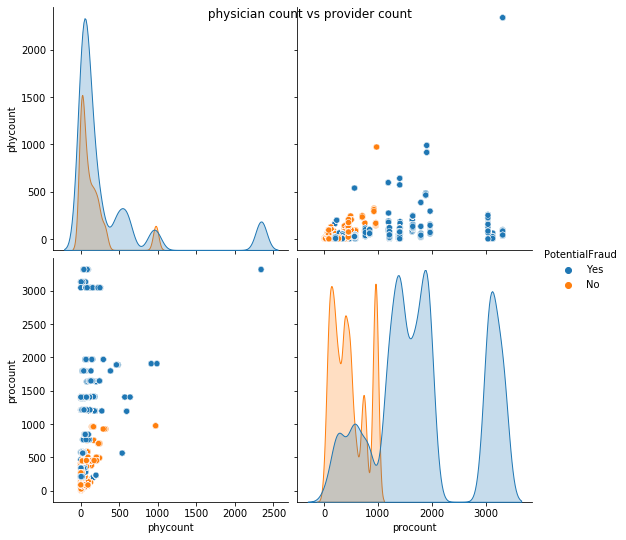

In [29]:
## num of cases attended by phy
attendingPhysician_count = final_data['AttendingPhysician'].value_counts().to_dict()
print('num of unique physician are: ',len(attendingPhysician_count))

## num of cases covered by pro
provider_count = final_data['Provider'].value_counts().to_dict()
print('num of unique provider are :',len(provider_count))

## adding phycount column by mapping num of cases attended by phy with AttendingPhysician 
final_data['phycount']=final_data['AttendingPhysician'].map(attendingPhysician_count)

## adding procount column by mapping num of cases covered by pro with Provider 
final_data['procount']=final_data['Provider'].map(provider_count)

sns.pairplot(final_data,hue='PotentialFraud',vars=['phycount','procount'],height=3.8)
plt.suptitle(' physician count vs provider count ')
plt.show()


### conclusion
1. Top 5 Physician and Provider that occur together has class label: <br>
    (('PHY330576', 'PRV53918'), 'Yes') <br>
    (('PHY350277', 'PRV51567'), 'Yes') <br>
    (('PHY412132', 'PRV53797'), 'Yes') <br>
    (('PHY423534', 'PRV51459'), 'Yes') <br>
    (('PHY314027', 'PRV51459'), 'Yes') <br>
    provider PRV51459 even occur twice in top 5, so that provider may be highly making fraud claim 
2. This show, if top attended physician and top provider occur together, they are supposed to make fraud claim
3. so if famous physician and provider occur together, it is good to check the claim in more depth
4. from pair plot, it show that top attended and physician tend to make fraud claim


## 3.4. BeneID feature 

### 3.4.1. Univariate analysis - Analysing BeneID feature with bar plot for outpatient

top 5 BeneID are:  BENE118316    29
BENE42721     29
BENE143400    27
BENE63544     27
BENE63504     27
Name: BeneID, dtype: int64


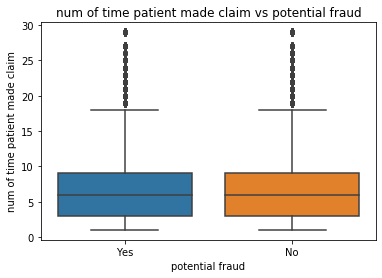

In [30]:
count_(train_outpatient,'BeneID','num of time patient made claim','num of time patient made claim vs potential fraud')

### conclusion
1. The most frequent patient BeneID is BENE42721 with 29 claim made
2. number of claim made by most patient is between 1 to 9 
3. The top 5 attended patient are BENE42721,BENE118316,BENE59303,BENE63544,BENE63504
4. patient who already made claim between 2 to 9 time tend to make more fraud claim


### 3.4.2. Univariate analysis - Analysing BeneID feature with bar plot for inpatient

top 5 BeneID are:  BENE134170    8
BENE117116    7
BENE119457    7
BENE121796    7
BENE62091     7
Name: BeneID, dtype: int64


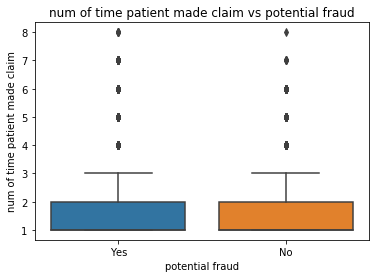

In [31]:
count_(train_inpatient,'BeneID','num of time patient made claim','num of time patient made claim vs potential fraud')

### conclusion
1. The most frequent patient BeneID is BENE134170 with 8 claim made
2. number of claim made by most patient is only 1 or 2 
3. The top 5 attended patient are BENE134170,BENE121796,BENE117116,BENE119457,BENE62091
4. inpatient will be occuring only for particular treatment , so analysing based on num of claim made by patient may not be useful


## 3.4.3. Bivariate analysis - pair plot on AttendingPhysician and BeneID  

In [32]:
## checking class label for top 5 Physician and BeneID that occur together

## for all row, if fraud take that physician and BeneID
benephy=[]
for i in range(len(final_data)):
    if final_data['PotentialFraud'][i]=='Yes':
        benephy.append((final_data['AttendingPhysician'][i],final_data['BeneID'][i]))

## counting num of time physician and BeneID occur together
benephy = dict(Counter(benephy))

## sorting descen on values of dict 
sortPhyBene = sorted(benephy.items(), key=lambda x: x[1], reverse=True)

## getting top physician and BeneID and their class label
labelPhyBene = []
for i in range(len(sortPhyBene[0:5])):
    df = final_data.loc[(final_data['AttendingPhysician'] == sortPhyBene[i][0][0]) & (final_data['BeneID'] == sortPhyBene[i][0][1])]
    labelPhyBene.append(((sortPhyBene[i][0][0],sortPhyBene[i][0][1]),df['PotentialFraud'].values[0]))
    

print('Top 5 Physician and BeneID that occur together has class label: ')
for i in labelPhyBene:
    print(i)

Top 5 Physician and BeneID that occur together has class label: 
(('PHY330576', 'BENE65747'), 'Yes')
(('PHY330576', 'BENE108047'), 'Yes')
(('PHY330576', 'BENE115161'), 'Yes')
(('PHY330576', 'BENE119950'), 'Yes')
(('PHY330576', 'BENE140460'), 'Yes')


num of unique physician are:  3675
num of unique bene are : 25237


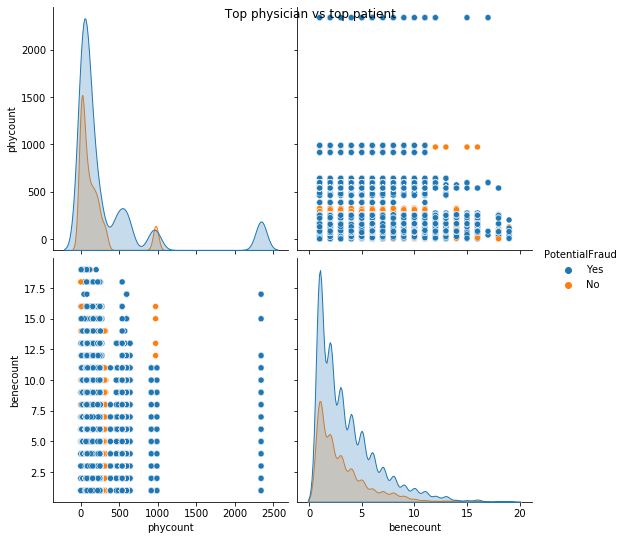

In [33]:
## num of cases attended by phy

attendingPhysician_count = final_data['AttendingPhysician'].value_counts().to_dict()
print('num of unique physician are: ',len(attendingPhysician_count))

## num of cases attended by BeneID
bene_count = final_data['BeneID'].value_counts().to_dict()
print('num of unique bene are :',len(bene_count))

## adding phycount column by mapping num of cases attended by phy with AttendingPhysician 
final_data['phycount']=final_data['AttendingPhysician'].map(attendingPhysician_count)

## adding phycount column by mapping num of cases attended by patient with BeneID 
final_data['benecount']=final_data['BeneID'].map(bene_count)

sns.pairplot(final_data,hue='PotentialFraud',vars=['phycount','benecount'],height=3.8)
plt.suptitle(' Top physician vs top patient \n\n')
plt.show()


### conclusion
1. Top 5 Physician and BeneID that occur together has class label: <br>
    (('PHY339042', 'BENE66093'), 'Yes') <br>
    (('PHY313322', 'BENE118316'), 'Yes') <br>
    (('PHY385072', 'BENE41087'), 'Yes') <br>
    (('PHY385072', 'BENE26003'), 'Yes') <br>
    (('PHY344367', 'BENE155227'), 'Yes') <br>
    physician PHY385072 even occur twice in top 5, so that physician may be highly making fraud claim 
2. This show, if top attended physician and top patient making claim occur together, they are supposed to make fraud claim
3. so if famous physician and patient with many claim occur together, it is good to check the claim in more depth
4. from pair plot, it show that top attended physician tend to make fraud claim


## 3.5. State feature 

### 3.5.1.Univariate analysis - Analysing State feature with bar plot  

num of different state : 52
33.0    7007
5.0     6388
Name: State, dtype: int64


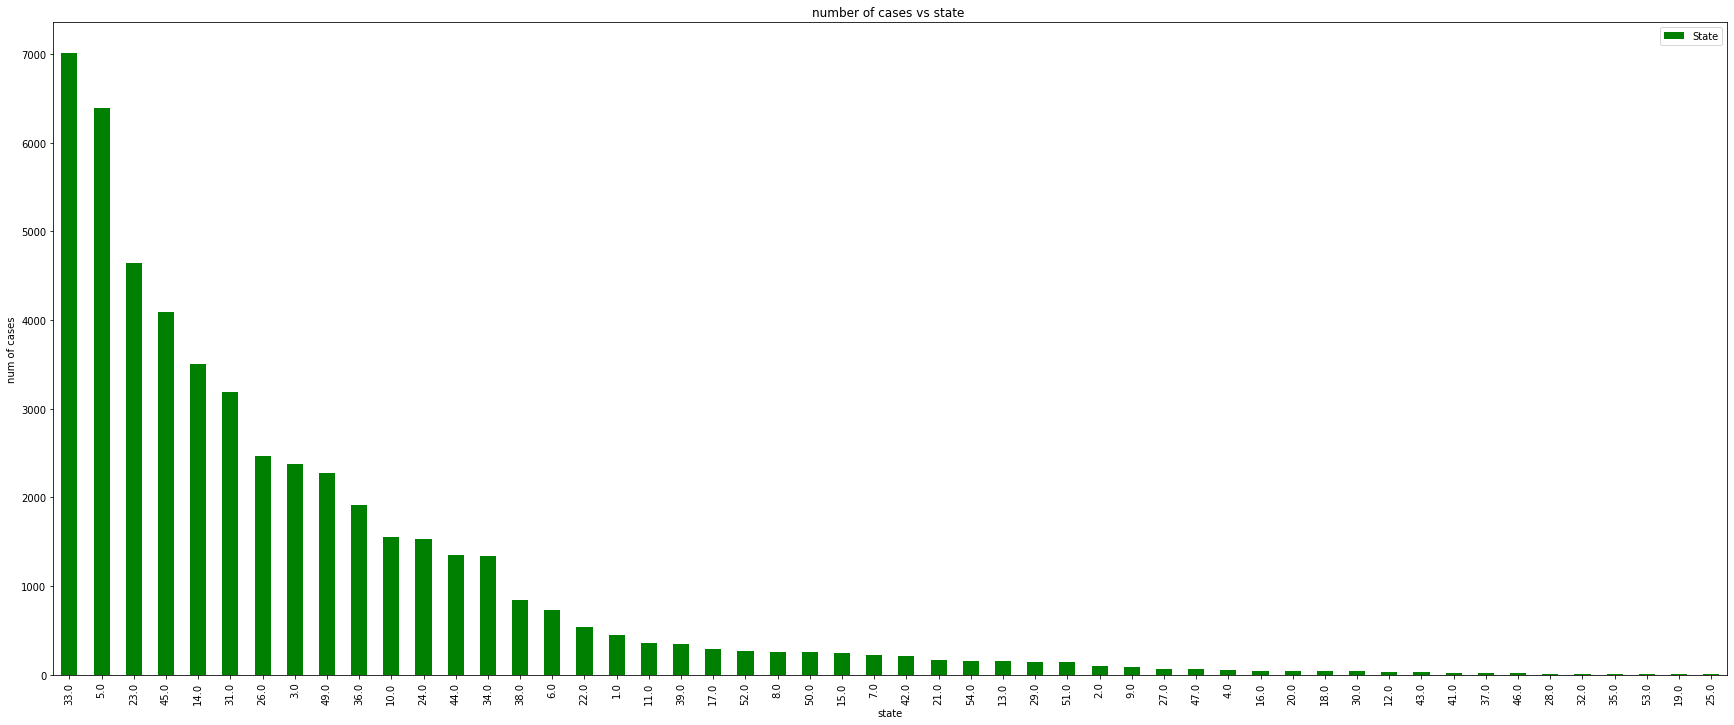

In [34]:
## num of cases in state

state_count = final_data['State'].value_counts()
print('num of different state :',len(state_count))
print(state_count[:5])
state_count.plot(kind='bar', color ='green',figsize=(30,12),legend='reverse',title='number of cases vs state ')
plt.xlabel('state')
plt.ylabel('num of cases')
plt.show()

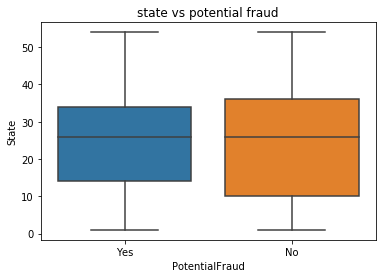

In [35]:
## state vs fraud

sns.boxplot(x='PotentialFraud',y='State',data=final_data)
plt.title('state vs potential fraud')
plt.show()

### 3.5.2. Bivariate analysis - Analysing AttendingPhysician and State feature with pair plot

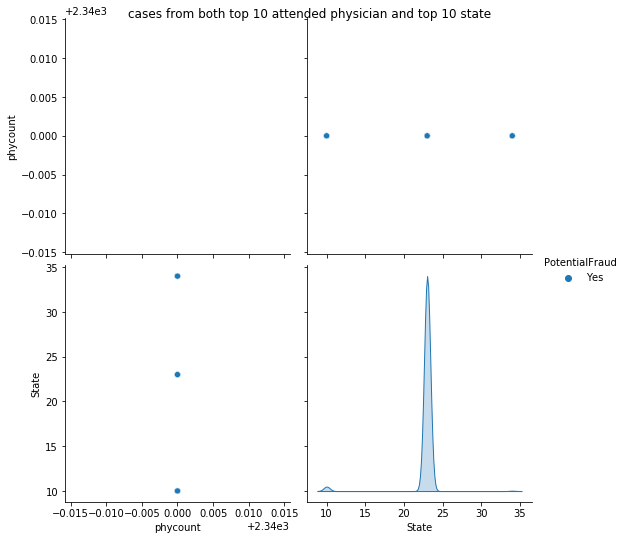

In [36]:
## cases from top 10 attended physician and top 10 state

phy = ['PHY330576','PHY350277','PHY412132','PHY423534','PHY314027','PRV52019','PRV55462','PRV54367','PRV53706','PRV55209']
state = [5,10,33,45,14,39,23,36,34,11]
phystate = final_data.loc[final_data['AttendingPhysician'].isin(phy) & final_data['State'].isin(state)]



## pair plot on top 10 attended physician and top 10 state
sns.pairplot(phystate,hue='PotentialFraud',vars=['phycount','State'],height=3.8)
plt.suptitle('cases from both top 10 attended physician and top 10 state')
plt.show()

### 3.5.3. Bivariate analysis - Analysing AttendingPhysician or State feature with pair plot 

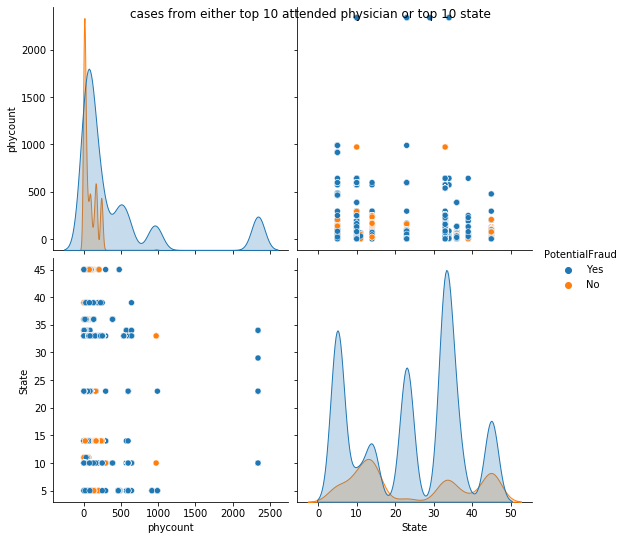

In [37]:
## cases from either top 10 attended physician or top 10 state

phy = ['PHY330576','PHY350277','PHY412132','PHY423534','PHY314027','PRV52019','PRV55462','PRV54367','PRV53706','PRV55209']
state = [5,10,33,45,14,39,23,36,34,11]
phyOrstate = final_data.loc[final_data['AttendingPhysician'].isin(phy) | final_data['State'].isin(state)]

## pair plot on either top 10 attended physician or top 10 state
sns.pairplot(phyOrstate,hue='PotentialFraud',vars=['phycount','State'],height=3.8)
plt.suptitle('cases from either top 10 attended physician or top 10 state')
plt.show()

In [38]:
phystateclass = phystate['PotentialFraud'].value_counts().to_dict()
phyOrstateclass = phyOrstate['PotentialFraud'].value_counts().to_dict()

print('percentage of class including both top 10 attended physician and top 10 state  :\n',phystateclass)
print('percentage of class either from top 10 attended physician or top 10 state :\n',phyOrstateclass)

percentage of class including both top 10 attended physician and top 10 state  :
 {'Yes': 2337}
percentage of class either from top 10 attended physician or top 10 state :
 {'Yes': 24959, 'No': 6168}


### conclusion
1. number of unique state is 52
2. cases from state category 5.0 have most 52714 case
3. cases from state category 9.0 have least 617 case
4. from bar plot, only top 10 cases have cases around and more than 20000
5. from box plot, yes and no class is almost same distributed
6. from pair plot, 

<li>cases attended including both top 10 attended physician and top 10 state (pair plot 1)</li>
    1. there is no non fraud claim made from top 10 physician and top state occuring together
    2. this show when top physician and top state(containing more cases) occur together, they tend to make fraud claim
<li>cases attended either from top 10 attended physician or top 10 state (pair plot 2)</li>
    1. this show when either top physician or state(containing more cases) occur, they tend to make fraud claim equal to non fraud claim. In this around 40% claim are made fraud. 
i.e., top physician and state(containing more cases) try to make fraud claim

## 3.6. DiagnosisCode

### 3.6.1. Univariate analysis - Analysing DiagnosisCode feature with bar plot 

In [39]:
## adding all code and checking top code in diagnosis

final_data_diagnosis = pd.DataFrame(columns = ['DiagnosisCode'])
final_data_diagnosis['DiagnosisCode'] = pd.concat([final_data["ClmDiagnosisCode_1"], 
                                           final_data["ClmDiagnosisCode_2"], 
                                           final_data["ClmDiagnosisCode_3"], 
                                           final_data["ClmDiagnosisCode_4"],
                                           final_data["ClmDiagnosisCode_5"], 
                                           final_data["ClmDiagnosisCode_6"],
                                           final_data["ClmDiagnosisCode_7"],
                                           final_data["ClmDiagnosisCode_8"],
                                           final_data["ClmDiagnosisCode_9"],
                                           final_data["ClmDiagnosisCode_10"]], axis=0)

In [40]:
final_data_diagnosis = final_data_diagnosis.dropna()
final_data_diagnosis.shape

(150410, 1)

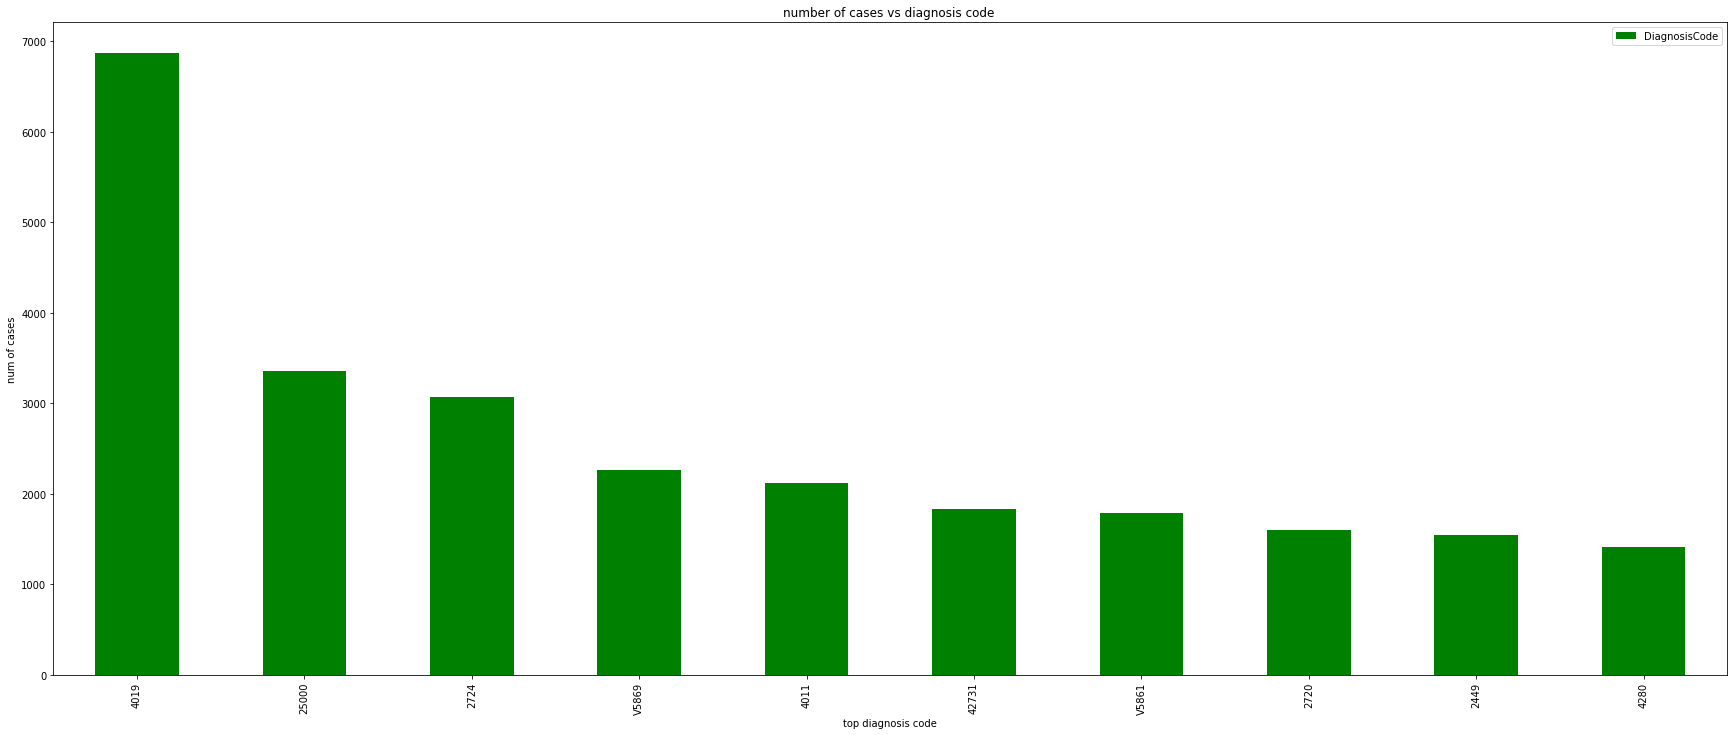

In [41]:
final_data_diagnosiscount = final_data_diagnosis['DiagnosisCode'].value_counts()[0:10]
final_data_diagnosiscount.plot(kind='bar', color ='green',figsize=(30,12),legend='reverse',title='number of cases vs diagnosis code ')
plt.xlabel('top diagnosis code')
plt.ylabel('num of cases')
plt.show()

### conclusion
1. top 10 diagnosis code and their num of occur are <br>
    '4019' -- 77056 <br>
    '25000' -- 37356 <br>
    '2724' -- 35763 <br>
    'V5869' -- 24904 <br>
    '4011' -- 23773 <br>
    '42731' -- 20138 <br>
    'V5861' -- 20001 <br>
    '2720' -- 18268 <br>
    '2449' -- 17600 <br>
    '4280' -- 15507 <br>
2. diagnosis code '4019' has 77056 highest num of occur
3. 4.4 % of patient undergone diagnosis code '4019'
4. these top 10 code are frequent so these code may be important in making fraud claim



## 3.7. InscClaimAmtReimbursed feature 

### 3.7.1. Univariate analysis - Analysing InscClaimAmtReimbursed feature with kde plot for outpatient

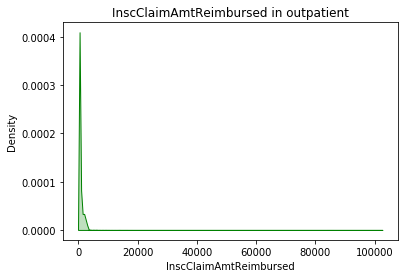

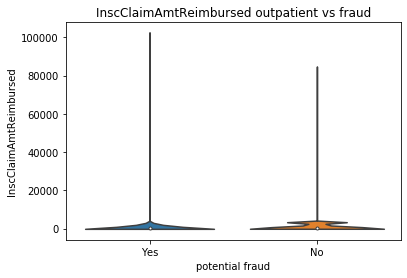

In [42]:
## using kde plot which use probability density function to analyse amount claimed 

sns.kdeplot(train_outpatient['InscClaimAmtReimbursed'],shade=True,color='green',legend=False)
plt.title('InscClaimAmtReimbursed in outpatient')
plt.xlabel('InscClaimAmtReimbursed')
plt.show()


## InscClaimAmtReimbursed outpatient vs fraud

sns.violinplot(x='PotentialFraud',y='InscClaimAmtReimbursed', data=train_outpatient)
plt.title('InscClaimAmtReimbursed outpatient vs fraud')
plt.xlabel('potential fraud')
plt.ylabel('InscClaimAmtReimbursed')
plt.show()

### conclusion

1. this follows log normal distribution
2. this shows only few claim amount is greater than 20000
3. most of claims have amount ranging within 20000
4. few claim even reach 60000 showing that may be fraud claim



### 3.7.2. Univariate analysis -  Analysing InscClaimAmtReimbursed feature with kde plot for inpatient

In [43]:
## percentile to check amount below 99 and 100 percentile

# q = [0.97,0.98,0.99,1]
# for i in q:
#     print('percentile',i,'is',final_data.InscClaimAmtReimbursed_y.dropna().quantile(i))

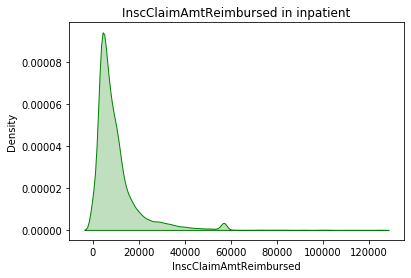

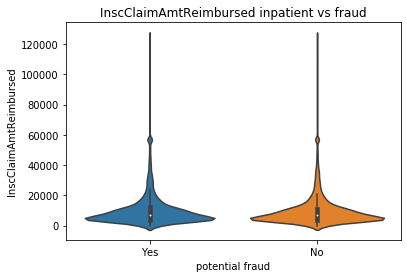

In [44]:
## using kde plot which use probability density function to analyse amount claimed 

sns.kdeplot(train_inpatient['InscClaimAmtReimbursed'],shade=True,color='green',legend=False)
plt.title('InscClaimAmtReimbursed in inpatient')
plt.xlabel('InscClaimAmtReimbursed')
plt.show()


## InscClaimAmtReimbursed inpatient vs fraud

sns.violinplot(x='PotentialFraud',y='InscClaimAmtReimbursed', data=train_inpatient)
plt.title('InscClaimAmtReimbursed inpatient vs fraud')
plt.xlabel('potential fraud')
plt.ylabel('InscClaimAmtReimbursed')
plt.show()

### conclusion

1. this follows log normal distribution
2. this shows only few claim amount is around 100000
3. most of claims have amount ranging within 3000
4. there is a huge difference between 99 and 100 percentile, showing it may be fraud claim
5. few claim even reach 100000 showing that may be fraud claim


## 3.8. Race feature 

### 3.8.1. Univariate analysis -  Analysing Race feature with bar plot  

In [45]:
## taking different race count

race_count = final_data['Race'].value_counts()
print(race_count)

1.0    41550
2.0     5121
3.0     2121
5.0     1208
Name: Race, dtype: int64


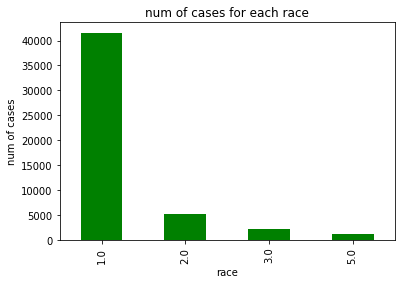

In [46]:
## num of cases for each race

race_count.plot(kind='bar', color ='green',title='num of cases for each race')
plt.xlabel('race')
plt.ylabel('num of cases')
plt.show()

### 3.8.2. checking race feature with potential fraud using violin plot

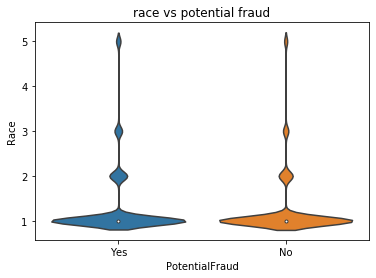

In [47]:
sns.violinplot(x='PotentialFraud',y='Race',data=final_data)
plt.title('race vs potential fraud')
plt.show()

### conclusion
1. bar plot shows people belonging to race with category 1 occur more than other
2. further it is checked with violin plot on potential fraud 
3. this violin plot give that race 1 has made more fraud claim than other
4. other category only very few and vary with same distribution on fraud or non fraud



## 3.9. IPAnnualReimbursementAmt, OPAnnualReimbursementAmt feature 

### 3.9.1. Univariate analysis -  Analysing IPAnnualReimbursementAmt feature with box plot

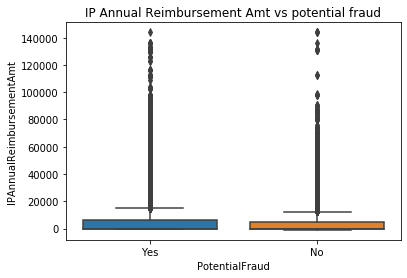

In [48]:
sns.boxplot(x='PotentialFraud',y='IPAnnualReimbursementAmt', data=final_data)
plt.title('IP Annual Reimbursement Amt vs potential fraud')
plt.show() 

### conclusion
1. number of fraud claim have more range than non fraud claim
2. but fraud and non fraud cases overlap fully which do not help to differntiate them
3. but it shows that highest amound claimed was fraud claim



### 3.9.2. Univariate analysis -  Analysing OPAnnualReimbursementAmt feature with box plot

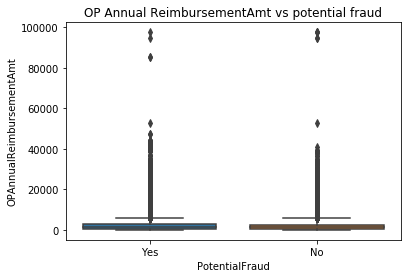

In [49]:
sns.boxplot(x='PotentialFraud',y='OPAnnualReimbursementAmt', data=final_data)
plt.title('OP Annual ReimbursementAmt vs potential fraud')
plt.show()


### conclusion
1. number of fraud claim have same range as non fraud claim
2. but fraud and non fraud cases overlap fully which do not help to differntiate them
3. but it shows that highest amound claimed was fraud claim
4. this analysis on IP and OP amount show fraud claims are paid highest than non fraud, which show that if amount for claim is high more analysis should be done on that claim to check if it is fraud or not



### 3.10. Bivariate analysis - pair plot on InscClaimAmtReimbursed and IPAnnualReimbursementAmt

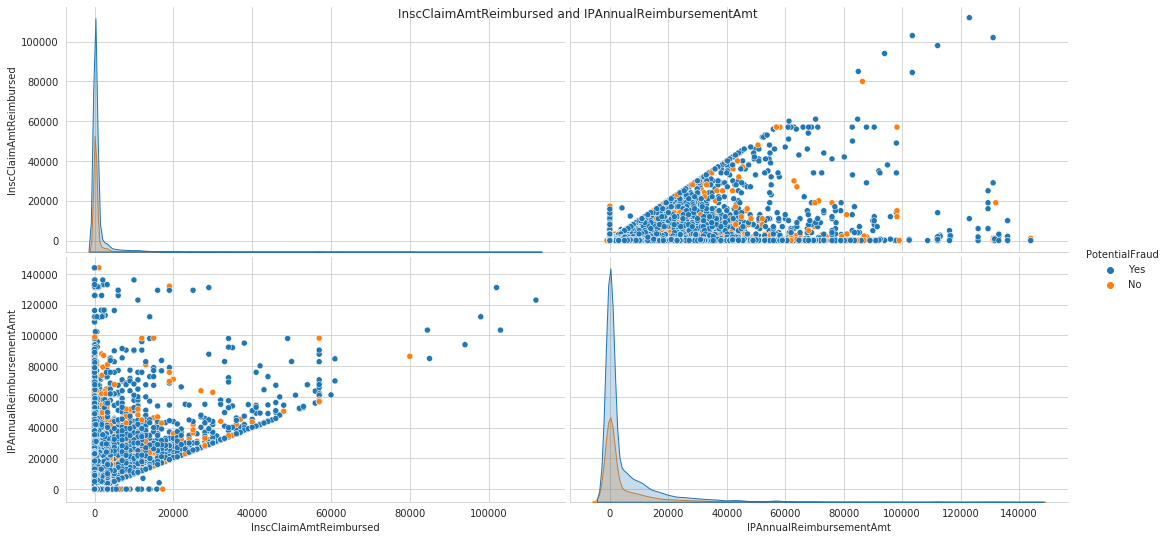

In [50]:
sns.set_style("whitegrid")
sns.pairplot(final_data,hue='PotentialFraud',vars=['InscClaimAmtReimbursed','IPAnnualReimbursementAmt'],height=3.8,aspect=2)
plt.suptitle('InscClaimAmtReimbursed and IPAnnualReimbursementAmt')
plt.show()


### conclusion
1. InscClaimAmtReimbursed and IPAnnualReimbursementAmt overlap more, but show that some fraud claim are made with higher amount tha non fraud claim
2. this show these two feature can help in classifying fraud claim that are made with higher amount



## 3.11. Bivariate analysis - pair plot on State,County,Race 

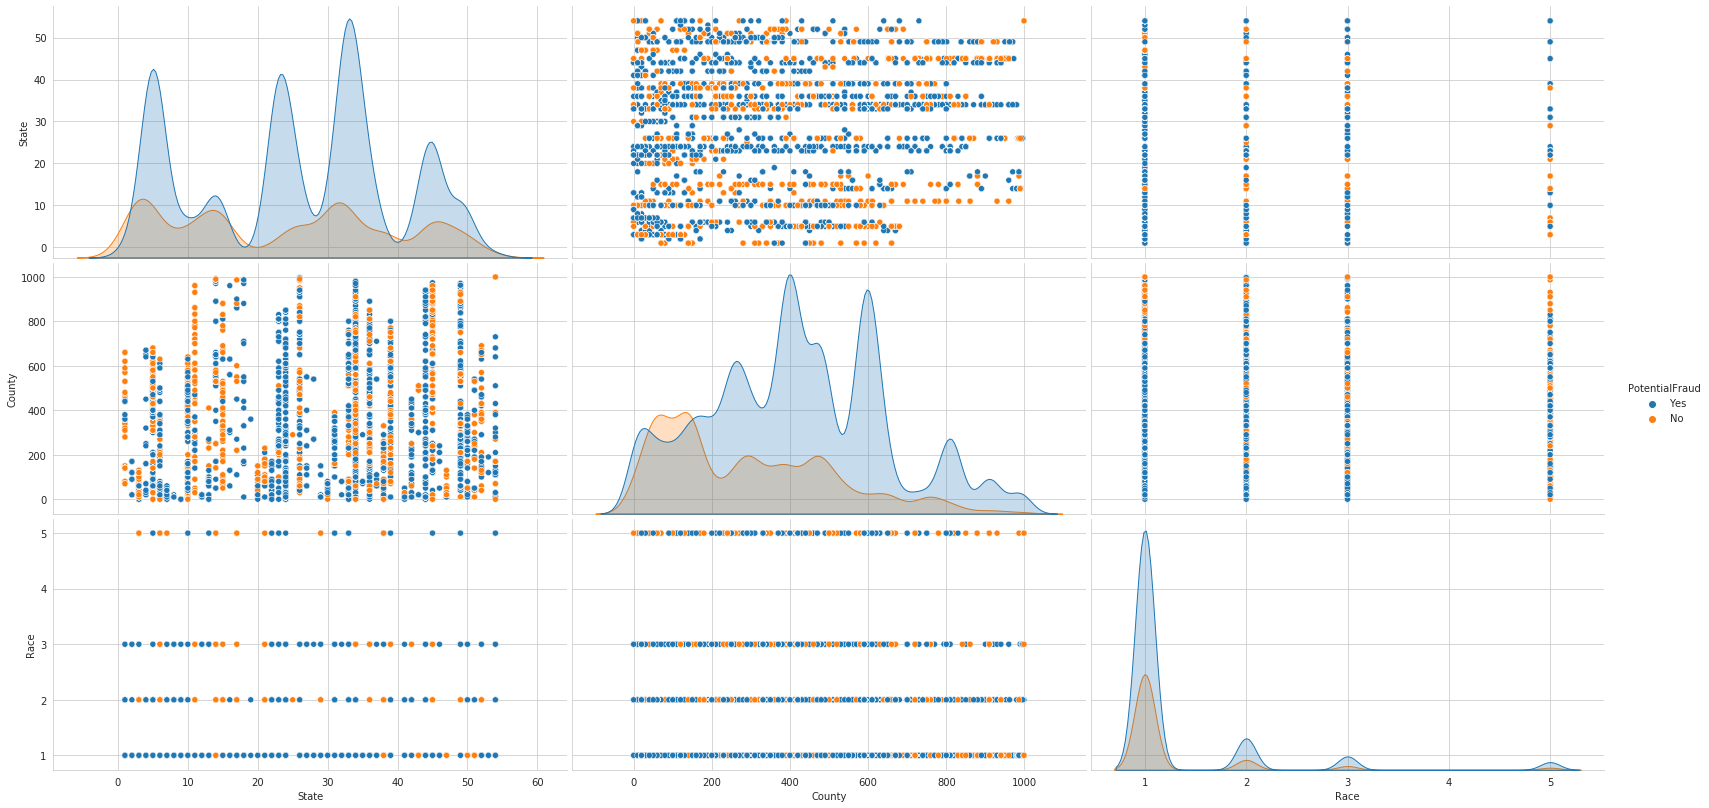

In [51]:
sns.set_style("whitegrid")
sns.pairplot(final_data,hue='PotentialFraud',vars=['State','County','Race'],height=3.8,aspect=2)
plt.show()


### conclusion
1. state feature tend to show some fraud claim in some state, but when combined with country and race it do not differ any fraud and non fraud claim
2. fraud and non fraud claim overlap in all case 

## 3.12. AdmissionDt and DischargeDt in inpatient 

In [52]:
## converting non-null object type col to datetime64
train_inpatient['AdmissionDt']= pd.to_datetime(train_inpatient['AdmissionDt'])
train_inpatient['DischargeDt']= pd.to_datetime(train_inpatient['DischargeDt'])
train_inpatient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43792 entries, 0 to 43791
Data columns (total 34 columns):
BeneID                     40474 non-null object
ClaimID                    40474 non-null object
ClaimStartDt               40474 non-null object
ClaimEndDt                 40474 non-null object
Provider                   43792 non-null object
InscClaimAmtReimbursed     40474 non-null float64
AttendingPhysician         40362 non-null object
OperatingPhysician         23830 non-null object
OtherPhysician             4690 non-null object
AdmissionDt                40474 non-null datetime64[ns]
ClmAdmitDiagnosisCode      40474 non-null object
DeductibleAmtPaid          39575 non-null float64
DischargeDt                40474 non-null datetime64[ns]
DiagnosisGroupCode         40474 non-null object
ClmDiagnosisCode_1         40474 non-null object
ClmDiagnosisCode_2         40248 non-null object
ClmDiagnosisCode_3         39798 non-null object
ClmDiagnosisCode_4         38940 non-null

### number of days  admitted 

In [53]:
train_inpatient['numOfDaysAdmitted'] = train_inpatient['DischargeDt'] - train_inpatient['AdmissionDt']

In [54]:
train_inpatient['numOfDaysAdmitted'] = train_inpatient['numOfDaysAdmitted'].fillna(0)

In [55]:
## converting days to int
train_inpatient['numOfDaysAdmitted'] = train_inpatient['numOfDaysAdmitted'].dt.days.astype('int64')

### 3.12.1. numOfDaysAdmitted vs PotentialFraud using countplot 

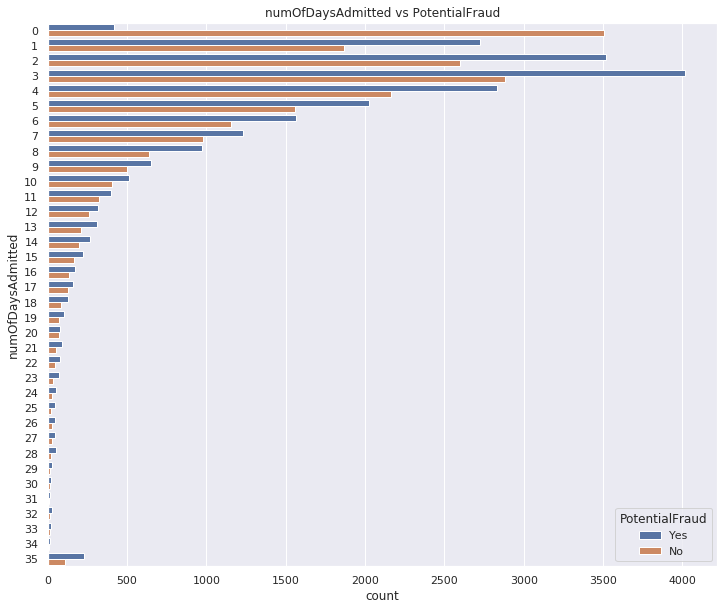

In [56]:
plt.close()
sns.set(rc={'figure.figsize':(12,10)})
ax = sns.countplot(y='numOfDaysAdmitted',data=train_inpatient,hue='PotentialFraud')
ax.set_title('numOfDaysAdmitted vs PotentialFraud')
plt.show()

### 3.12.2. Bivariate analysis - numOfDaysAdmitted and AttendingPhysician using pair plot 

num of unique physician are:  11604


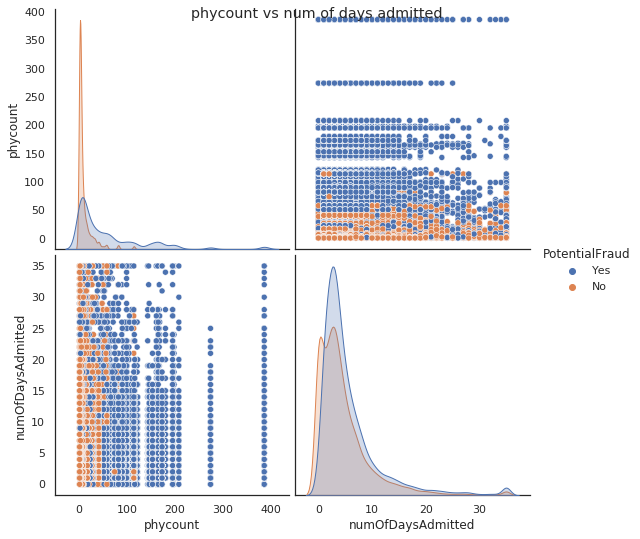

In [57]:
## num of cases attended by phy 
attendingPhysician_count = train_inpatient['AttendingPhysician'].value_counts().to_dict()
print('num of unique physician are: ',len(attendingPhysician_count))

train_inpatient['phycount']=train_inpatient['AttendingPhysician'].map(attendingPhysician_count)

sns.set_style("white")
sns.pairplot(train_inpatient,hue='PotentialFraud',vars=['phycount','numOfDaysAdmitted'],height=3.8)
plt.suptitle('phycount vs num of days admitted')
plt.show()



### conclusion
1. num of day patient admitted can be got from, discharge date - admitted
2. from counterplot, patient who are admitted between 2 to 7 tend to show more fraud claim
3. from pair plot, top attended physician tend to make more fraud claim in all case of number of day admitted
4. from all analysis it is shown that top attended physician tend to make fraud claim


## 3.13. Gender feature

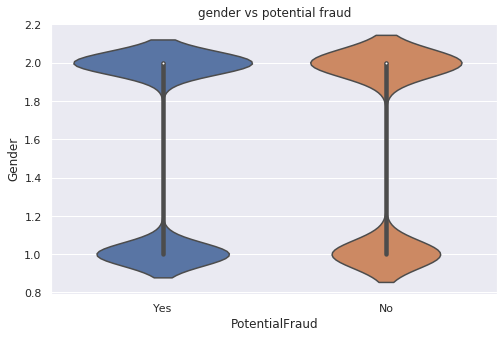

In [58]:
sns.set(rc={'figure.figsize':(8,5)})
sns.violinplot(x='PotentialFraud',y='Gender',data=final_data)
plt.title('gender vs potential fraud')
plt.show()

### conclusion
1. gender 2 occur more num of times than 1
2. num of fraud occur more time in gender 2 than gender 1

## summary

1. class distribution - 
         percentage of fraud class :  36.5615138912, 
         percentage of non fraud class :  63.4384861088
2. If a physician has attended many number of cases previously, there is more chance of making fraud claim next time
3. If a provider has high num of cases covered by a provider previously, there is more chance to do fraud claim
4. If top attended physician and top covered provider occur together they tend to make fraud claim 
5. If top attended physician and top patient who made more claim occur together, they are supposed to make fraud claim.
    outpatient made 1 - 9 claim previously tend to make fraud claim 
6. few state show more fraud claim
7. If top attended physician and top ten state(containing more cases) occur either together or separate, it more possibility of fraud claim 
8. top occuring diagnosis code that most patient undergone are '4019','25000','2724','V5869','4011','42731','V5861','2720','2449','4280' 
9. range of fraud claim made by outpatient is around 5000 and for inpatient 20000
10. race 1 occur more number of time, and has most fraud claim
11. reimbursed amount distribution in fraud and non fraud claim almost overlap
12. state, country, race has distribution almost overlap 
13. If patient is admitted 2 to 7 days previously, they tend to make fraud claim next time

### Main feature that help in classify fraud and non fraud

1. provider count ( has high num of cases covered ) is main feature
2. physician count ( has attended many number of cases ) is next main feature

# 4. Data preprocessing

In [59]:
final_data.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCon

In [60]:
final_data.shape

(50000, 58)

## 4.1. checking null value

In [61]:
## checking null value

final_data.isnull().sum()

BeneID                                 0
ClaimID                                0
ClaimStartDt                           0
ClaimEndDt                             0
Provider                               0
InscClaimAmtReimbursed                 0
AttendingPhysician                   138
OperatingPhysician                 39829
OtherPhysician                     32998
AdmissionDt                        46443
ClmAdmitDiagnosisCode              36914
DeductibleAmtPaid                     80
DischargeDt                        46443
DiagnosisGroupCode                 46443
ClmDiagnosisCode_1                   962
ClmDiagnosisCode_2                 17712
ClmDiagnosisCode_3                 28227
ClmDiagnosisCode_4                 35235
ClmDiagnosisCode_5                 39947
ClmDiagnosisCode_6                 42418
ClmDiagnosisCode_7                 44119
ClmDiagnosisCode_8                 45185
ClmDiagnosisCode_9                 46221
ClmDiagnosisCode_10                49564
ClmProcedureCode

In [62]:
print('num of null value in ClmProcedureCode_5 :',final_data['ClmProcedureCode_5'].isnull().sum())
print('num of null value in ClmProcedureCode_6 :',final_data['ClmProcedureCode_6'].isnull().sum())

num of null value in ClmProcedureCode_5 : 50000
num of null value in ClmProcedureCode_6 : 50000


In [63]:
## removing ClmProcedureCode_5, ClmProcedureCode_6 as it has all null 

final_data.drop('ClmProcedureCode_5',axis=1,inplace=True)
final_data.drop('ClmProcedureCode_6',axis=1,inplace=True)

## remove as it has all value as same

final_data.drop('NoOfMonths_PartACov',axis=1,inplace=True)
final_data.drop('NoOfMonths_PartBCov',axis=1,inplace=True)

In [64]:
## replacing null with 0

colFillna = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2',
             'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
             'ClmDiagnosisCode_5','ClmDiagnosisCode_6',
             'ClmDiagnosisCode_7','ClmDiagnosisCode_8',
             'ClmDiagnosisCode_9','ClmDiagnosisCode_10',
             'ClmProcedureCode_1','ClmProcedureCode_2',
             'ClmProcedureCode_3','ClmProcedureCode_4',
             'DiagnosisGroupCode','ClmAdmitDiagnosisCode']

final_data[colFillna]= final_data[colFillna].replace({np.nan:0})

In [65]:
## replacing null with mode

colFillmode = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2',
             'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
             'ClmDiagnosisCode_5','ClmDiagnosisCode_6',
             'ClmDiagnosisCode_7','ClmDiagnosisCode_8',
             'ClmDiagnosisCode_9','ClmDiagnosisCode_10',
             'ClmProcedureCode_1','ClmProcedureCode_2',
             'ClmProcedureCode_3','ClmProcedureCode_4',
             'DiagnosisGroupCode','ClmAdmitDiagnosisCode']

for i in colFillna:
    mode = final_data[i].mode()[0]
    print(i,'mode :',mode)
    final_data[i]=final_data[i].fillna(mode)

ClmDiagnosisCode_1 mode : 4019
ClmDiagnosisCode_2 mode : 0
ClmDiagnosisCode_3 mode : 0
ClmDiagnosisCode_4 mode : 0
ClmDiagnosisCode_5 mode : 0
ClmDiagnosisCode_6 mode : 0
ClmDiagnosisCode_7 mode : 0
ClmDiagnosisCode_8 mode : 0
ClmDiagnosisCode_9 mode : 0
ClmDiagnosisCode_10 mode : 0
ClmProcedureCode_1 mode : 0.0
ClmProcedureCode_2 mode : 0.0
ClmProcedureCode_3 mode : 0.0
ClmProcedureCode_4 mode : 0.0
DiagnosisGroupCode mode : 0
ClmAdmitDiagnosisCode mode : 0


In [66]:
final_data.isnull().sum()

BeneID                                 0
ClaimID                                0
ClaimStartDt                           0
ClaimEndDt                             0
Provider                               0
InscClaimAmtReimbursed                 0
AttendingPhysician                   138
OperatingPhysician                 39829
OtherPhysician                     32998
AdmissionDt                        46443
ClmAdmitDiagnosisCode                  0
DeductibleAmtPaid                     80
DischargeDt                        46443
DiagnosisGroupCode                     0
ClmDiagnosisCode_1                     0
ClmDiagnosisCode_2                     0
ClmDiagnosisCode_3                     0
ClmDiagnosisCode_4                     0
ClmDiagnosisCode_5                     0
ClmDiagnosisCode_6                     0
ClmDiagnosisCode_7                     0
ClmDiagnosisCode_8                     0
ClmDiagnosisCode_9                     0
ClmDiagnosisCode_10                    0
ClmProcedureCode

## 4.2. checking for duplicate row

In [67]:
print('num of claim :',final_data.shape[0])
print('num of unique claim :',len(final_data['ClaimID'].value_counts()))

num of claim : 50000
num of unique claim : 50000


## 4.3. PotentialFraud has yes and no - replacing with 1 and 0 

In [68]:
final_data['PotentialFraud'] = final_data['PotentialFraud'].map({'Yes':1,'No':0})

In [69]:
final_data['PotentialFraud'].value_counts()

1    35704
0    14296
Name: PotentialFraud, dtype: int64

## 4.4. RenalDiseaseIndicator has y and 0 - replacing with 1 and 0 

In [70]:
final_data['RenalDiseaseIndicator'] = final_data['RenalDiseaseIndicator'].map({'Y':1,'0':0})

In [71]:
final_data['RenalDiseaseIndicator'].value_counts()

0    40169
1     9831
Name: RenalDiseaseIndicator, dtype: int64

## 4.5. ChronicCond has 2 and 1 - replacing with 0 and 1 

In [72]:
final_data['ChronicCond_Alzheimer'] = final_data['ChronicCond_Alzheimer'].map({2:0,1:1})
final_data['ChronicCond_Heartfailure'] = final_data['ChronicCond_Heartfailure'].map({2:0,1:1})
final_data['ChronicCond_KidneyDisease'] = final_data['ChronicCond_KidneyDisease'].map({2:0,1:1})
final_data['ChronicCond_Cancer'] = final_data['ChronicCond_Cancer'].map({2:0,1:1})
final_data['ChronicCond_ObstrPulmonary'] = final_data['ChronicCond_ObstrPulmonary'].map({2:0,1:1})
final_data['ChronicCond_Depression'] = final_data['ChronicCond_Depression'].map({2:0,1:1})
final_data['ChronicCond_Diabetes'] = final_data['ChronicCond_Diabetes'].map({2:0,1:1})
final_data['ChronicCond_IschemicHeart'] = final_data['ChronicCond_IschemicHeart'].map({2:0,1:1})
final_data['ChronicCond_Osteoporasis'] = final_data['ChronicCond_Osteoporasis'].map({2:0,1:1})
final_data['ChronicCond_rheumatoidarthritis'] = final_data['ChronicCond_rheumatoidarthritis'].map({2:0,1:1})
final_data['ChronicCond_stroke'] = final_data['ChronicCond_stroke'].map({2:0,1:1})
final_data['Gender'] = final_data['Gender'].map({2:0,1:1})

## summary
1. no duplicate rows
2. PotentialFraud has yes and no - replacing with 1 and 0
3. RenalDiseaseIndicator has y and 0 - replacing with 1 and 0
4. ChronicCond has 2 and 1 - replacing with 0 and 1
5. diagnosis and procedure code has more null value ( procedure code 5, 6 has all value as null - removed those two column )
6. removed 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov' has same value for all row ( it may be due to error )


# 5. Feature engineering 

### 5.1. counting num of times patient made claim 
#### ( if a patient made more claim before, chnce of making fraud claim is more )

In [73]:
bene_count = final_data['BeneID'].value_counts().to_dict()

In [74]:
final_data['BeneCount'] = final_data['BeneID'].map(bene_count)

In [75]:
final_data['BeneCount'][0:5]

0    3
1    1
2    1
3    1
4    1
Name: BeneCount, dtype: int64

### 5.2. counting num of times provider covered claim 
#### ( if a provider is more famous, chnce of making fraud claim is more )

In [76]:
pro_count = final_data['Provider'].value_counts().to_dict()

In [77]:
final_data['ProviderCount'] = final_data['Provider'].map(pro_count)

In [78]:
final_data['ProviderCount'][0:5]

0    104
1    104
2    104
3    104
4    104
Name: ProviderCount, dtype: int64

### 5.3. counting num of times physician attended all patient
#### ( if a physician has attended many patient, chnce of making fraud claim is more )

In [79]:
attphy_count = final_data['AttendingPhysician'].value_counts().to_dict()

In [80]:
final_data['AttendingPhysicianCount'] = final_data['AttendingPhysician'].map(attphy_count)

In [81]:
## replacing null with 0

final_data['AttendingPhysicianCount'] = final_data['AttendingPhysicianCount'].fillna(0)

In [82]:
## replacing null with mode

mode = final_data['AttendingPhysicianCount'].mode()[0]
print('mode :',mode)
final_data['AttendingPhysicianCount']=final_data['AttendingPhysicianCount'].fillna(mode)

mode : 2340.0


In [83]:
final_data['AttendingPhysicianCount'][0:5]

0    1.0
1    1.0
2    1.0
3    2.0
4    3.0
Name: AttendingPhysicianCount, dtype: float64

## 5.4. num of days patient admitted
#### ( getting information from admissiondt,dischargedt)

In [84]:
df = pd.DataFrame(final_data,columns = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt']) 
df.dtypes

ClaimStartDt    object
ClaimEndDt      object
AdmissionDt     object
DischargeDt     object
dtype: object

In [85]:
## converting non-null object type of dt column to datetime

final_data['AdmissionDt']= pd.to_datetime(final_data['AdmissionDt'])
final_data['DischargeDt']= pd.to_datetime(final_data['DischargeDt'])
final_data['ClaimStartDt']= pd.to_datetime(final_data['ClaimStartDt'])
final_data['ClaimEndDt']= pd.to_datetime(final_data['ClaimEndDt'])

df = pd.DataFrame(final_data,columns = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt']) 
df.dtypes

ClaimStartDt    datetime64[ns]
ClaimEndDt      datetime64[ns]
AdmissionDt     datetime64[ns]
DischargeDt     datetime64[ns]
dtype: object

In [86]:
## filling na with 0

## calculating num of days admitted

final_data['numOfDaysAdmitted'] = final_data['DischargeDt'] - final_data['AdmissionDt']

## filling na with 0 
final_data['numOfDaysAdmitted'] = final_data['numOfDaysAdmitted'].fillna(0)

## converting days type to int
final_data['numOfDaysAdmitted'] = final_data['numOfDaysAdmitted'].dt.days.astype('int64')
final_data['numOfDaysAdmitted'][0:5]

0     6
1     0
2    12
3    18
4     4
Name: numOfDaysAdmitted, dtype: int64

In [87]:
## filling 0 with mean ( mode is 0 so mean is used )

mean = final_data['numOfDaysAdmitted'].mean()
mean = round(mean,1)
print('mean :',mean)
final_data['numOfDaysAdmitted']=final_data['numOfDaysAdmitted'].replace({0:mean})
final_data['numOfDaysAdmitted'][0:5]

mean : 0.4


0     6.0
1     0.4
2    12.0
3    18.0
4     4.0
Name: numOfDaysAdmitted, dtype: float64

## 5.5. num of days for claim took to reimbursed

#### ( getting information from ClaimStartDt,ClaimEndDt)

In [88]:
## filling na with 0

## calculating num of days for claim

final_data['numOfDaysForClaim'] = final_data['ClaimEndDt'] - final_data['ClaimStartDt']

## filling na with 0 
final_data['numOfDaysForClaim'] = final_data['numOfDaysForClaim'].fillna(0)

## converting days type to int
final_data['numOfDaysForClaim'] = final_data['numOfDaysForClaim'].dt.days.astype('int64')
final_data['numOfDaysForClaim'][0:5]

0     6
1     0
2    12
3    18
4     4
Name: numOfDaysForClaim, dtype: int64

In [89]:
## filling 0 with mean ( mode is 0 so mean is used )

mean = final_data['numOfDaysForClaim'].mean()
mean = round(mean,1)
print('mean :',mean)
final_data['numOfDaysForClaim']=final_data['numOfDaysForClaim'].replace({0:mean})
final_data['numOfDaysForClaim'][0:5]

mean : 1.7


0     6.0
1     1.7
2    12.0
3    18.0
4     4.0
Name: numOfDaysForClaim, dtype: float64

## 5.6. calculating total ip,op amount reimburse 

In [90]:
final_data[['IPAnnualReimbursementAmt','OPAnnualReimbursementAmt','IPAnnualDeductibleAmt','OPAnnualDeductibleAmt']][0:5]

,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt
0,36000.0,60.0,3204.0,70.0
1,24000.0,450.0,2136.0,200.0
2,19000.0,100.0,1068.0,20.0
3,17000.0,1050.0,1068.0,540.0
4,27000.0,450.0,2136.0,160.0


In [91]:
## adding ip op amount

ip_op_total_amount = final_data['IPAnnualReimbursementAmt'] + final_data['OPAnnualReimbursementAmt']

In [92]:
## adding deductible amount

ip_op_ded_amount = final_data['IPAnnualDeductibleAmt'] + final_data['OPAnnualDeductibleAmt']

In [93]:
## total amount - deductible amount

ip_op_total_amount = ip_op_total_amount - ip_op_ded_amount

In [94]:
final_data['ip_op_total_amount'] = ip_op_total_amount

In [95]:
final_data['ip_op_total_amount'][0:5]

0    32786.0
1    22114.0
2    18012.0
3    16442.0
4    25154.0
Name: ip_op_total_amount, dtype: float64

## 5.7. calculating total disease patient was diagnosed before  

In [96]:
## adding disease diagnosed on patient before 

num_of_chronic = final_data['RenalDiseaseIndicator'] + final_data['ChronicCond_Alzheimer'] + \
                    final_data['ChronicCond_Heartfailure'] + final_data['ChronicCond_KidneyDisease'] + \
                    final_data['ChronicCond_Cancer'] + final_data['ChronicCond_ObstrPulmonary'] + \
                    final_data['ChronicCond_Depression'] + final_data['ChronicCond_Diabetes'] + \
                    final_data['ChronicCond_IschemicHeart'] + final_data['ChronicCond_Osteoporasis'] + \
                    final_data['ChronicCond_rheumatoidarthritis'] + final_data['ChronicCond_stroke'] 

In [97]:
final_data['num_of_chronic'] = num_of_chronic
final_data['num_of_chronic'][0:5]

0    7
1    4
2    5
3    2
4    6
Name: num_of_chronic, dtype: int64

## 5.8. calculating num of diagnosis procedure undergonw by patient 

In [98]:
## converting each row into array 

num_of_diag_proc = final_data[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 
       'DiagnosisGroupCode','ClmAdmitDiagnosisCode']].values

In [99]:
num_of_diag_proc

array([['1970', '4019', '5853', ..., 0.0, '201', '7866'],
       ['V7183', '53081', '78959', ..., 0.0, 0, 0],
       ['4240', '2639', '2948', ..., 0.0, '987', '45340'],
       ...,
       ['4019', '2920', '2720', ..., 0.0, 0, 0],
       ['5184', 0, 0, ..., 0.0, 0, 0],
       ['72886', 0, 0, ..., 0.0, 0, 0]], dtype=object)

In [100]:
len(num_of_diag_proc)

50000

In [101]:
## counting non zero value in each row

countnum_of_diag_proc = []
for i in range(len(num_of_diag_proc)):
    countnum_of_diag_proc.append(np.count_nonzero(num_of_diag_proc[i]))

In [102]:
len(countnum_of_diag_proc)

50000

In [103]:
final_data['num_of_diag_proc'] = countnum_of_diag_proc

In [104]:
final_data['num_of_diag_proc'][0:5]

0    11
1     9
2    13
3    12
4    10
Name: num_of_diag_proc, dtype: int64

## 5.9. calculating num of physician treating patient 

In [105]:
## fill na with 0

num_of_phy = final_data[['AttendingPhysician','OperatingPhysician','OtherPhysician']].fillna(0).values

In [106]:
num_of_phy

array([['PHY390922', 0, 0],
       ['PHY365867', 'PHY327147', 0],
       ['PHY349293', 'PHY370861', 'PHY363291'],
       ...,
       ['PHY383351', 'PHY389217', 'PHY385898'],
       ['PHY347629', 0, 0],
       ['PHY429147', 0, 'PHY424276']], dtype=object)

In [107]:
## counting non zero value in each row

countnum_of_phy = []
for i in range(len(num_of_phy)):
    countnum_of_phy.append(np.count_nonzero(num_of_phy[i]))

In [108]:
final_data['num_of_phy'] = countnum_of_phy

In [109]:
final_data['num_of_phy'][0:5]

0    1
1    2
2    3
3    2
4    3
Name: num_of_phy, dtype: int64

In [110]:
np.count_nonzero(final_data['num_of_phy'])

49863

In [111]:
## replacing 0 with mode 

mode = final_data['num_of_phy'].mode()[0]
print(mode)
final_data['num_of_phy']=final_data['num_of_phy'].replace({0:mode})

1


In [112]:
np.count_nonzero(final_data['num_of_phy'])

50000

## 5.10. one hot encoding diagnosis code 
#### number of category in each column is more than 1000
#### so picking top 10 category 
#### encode column with value from top 10 category as 1 else 0 

In [113]:
diagnosis_code = final_data[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'DiagnosisGroupCode','ClmAdmitDiagnosisCode']]

In [114]:
## total category in each column

for i in diagnosis_code.columns:
    print('num of category in',i,'is',len(diagnosis_code[i].unique()))

num of category in ClmDiagnosisCode_1 is 6591
num of category in ClmDiagnosisCode_2 is 2585
num of category in ClmDiagnosisCode_3 is 2200
num of category in ClmDiagnosisCode_4 is 1918
num of category in ClmDiagnosisCode_5 is 1611
num of category in ClmDiagnosisCode_6 is 1421
num of category in ClmDiagnosisCode_7 is 1301
num of category in ClmDiagnosisCode_8 is 1118
num of category in ClmDiagnosisCode_9 is 1015
num of category in ClmDiagnosisCode_10 is 251
num of category in DiagnosisGroupCode is 647
num of category in ClmAdmitDiagnosisCode is 1747


In [115]:
## getting top 10 code 

top10 = ['4019','25000','2724','V5869','4011','42731','V5861','2720','2449','4280']

In [116]:
## 1. pick one category 4019
## 2. pick one column (eg ClmDiagnosisCode_1)
## 3. add new column with name diagnosis 4019
## 4. using np.where check for category 4019 presnt int that column or not, if present replace with 1 else 0, put in column diagnosis4019
## 5. again same 4019 is encoded for ClmDiagnosisCode_2
## 6. here it will take ClmDiagnosisCode_2 and check for 4019 category and replace with 1 if present,
      ## else it will check whether it is already encoded for ClmDiagnosisCode_1 ( if already encoded means it will have value 1)
     ## here if 1 it will keep same value as 1, else 0
## 7. step 5 6 is repeated for all diagnosis column, after doing for all, next category is picked and for all category 
     ## here ten new column will be added, each row will represent whether that code is present or not

for col in top10:
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_1']==col,1,0)
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_2']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_3']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_4']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_5']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_6']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_7']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_8']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_9']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_10']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['DiagnosisGroupCode']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
    final_data['diagnosis_'+str(col)] = np.where(final_data['ClmAdmitDiagnosisCode']==col,1,\
                                   np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))

## 5.11. one hot encoding procedure code 
#### number of category very less and most of value is na. non na is around 0.8 % 
#### so picking top 5 category 
#### encode column with value from top 5 category as 1 else 0

In [117]:
procedure_code = final_data[['ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4']]

In [118]:
## total category in each column

for i in procedure_code.columns:
    print('num of category in',i,'is',len(procedure_code[i].unique()))

num of category in ClmProcedureCode_1 is 405
num of category in ClmProcedureCode_2 is 97
num of category in ClmProcedureCode_3 is 38
num of category in ClmProcedureCode_4 is 5


In [119]:
## procedure with na

final_data_proc = pd.DataFrame(columns = ['ProCode'])
final_data_proc['ProCode'] = pd.concat([final_data["ClmProcedureCode_1"], 
                                           final_data["ClmProcedureCode_2"], 
                                           final_data["ClmProcedureCode_3"], 
                                           final_data["ClmProcedureCode_4"]], axis=0).dropna()

print(final_data_proc.shape)

(200000, 1)


In [120]:
np.count_nonzero(final_data_proc)

2648

In [121]:
print('percentage of non zero value in procedure :',(29887/2232844)*100)

percentage of non zero value in procedure : 1.338517155699189


In [122]:
## procedure without na

final_data_proc = pd.DataFrame(columns = ['ProCode'])
final_data_proc['ProCode'] = pd.concat([final_data["ClmProcedureCode_1"], 
                                           final_data["ClmProcedureCode_2"], 
                                           final_data["ClmProcedureCode_3"], 
                                           final_data["ClmProcedureCode_4"]], axis=0).dropna()

print(final_data_proc.shape)

(200000, 1)


In [123]:
np.count_nonzero(final_data_proc)

2648

In [124]:
## getting top 5 code 

topproc = final_data_proc['ProCode'].value_counts()
topproc.index[0:10]

Float64Index([0.0, 4019.0, 8154.0, 2724.0, 9904.0, 66.0, 3893.0, 3995.0,
              4516.0, 3722.0],
             dtype='float64')

In [125]:
top5 = [4019.0, 9904.0, 2724.0, 8154.0, 66.0]

In [126]:
## 1. pick one category 4019
## 2. pick one column (eg ClmProcedureCode_1)
## 3. add new column with name diagnosis 4019
## 4. using np.where check for category 4019 presnt int that column or not, if present replace with 1 else 0, put in column procedure4019
## 5. again same 4019 is encoded for ClmProcedureCode_2
## 6. here it will take ClmProcedureCode_2 and check for 4019 category and replace with 1 if present,
      ## else it will check whether it is already encoded for ClmProcedureCode_2 ( if already encoded means it will have value 1)
     ## here if 1 it will keep same value as 1, else 0
## 7. step 5 6 is repeated for all procedure column, after doing for all, next category is picked and for all category 
     ## here new column will be added, each row will represent whether that code is present or not

for col in top5:
    final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_1']==col,1,0)
    final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_2']==col,1,\
                                   np.where(final_data['procedure_'+str(col)]==1,1,0 ))
    final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_3']==col,1,\
                                   np.where(final_data['procedure_'+str(col)]==1,1,0 ))
    final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_4']==col,1,\
                                   np.where(final_data['procedure_'+str(col)]==1,1,0 ))

## 5.12. frequency encoding diagnosis, procedure code
    counting num of times code occured, replacing with count 

In [127]:
## col with 0 value present

DiagnosisCode_1_count = final_data['ClmDiagnosisCode_1'].value_counts().to_dict()
DiagnosisCode_1_count[0]=0

DiagnosisCode_2_count = final_data['ClmDiagnosisCode_2'].value_counts().to_dict()
DiagnosisCode_2_count[0]=0

DiagnosisCode_3_count = final_data['ClmDiagnosisCode_3'].value_counts().to_dict()
DiagnosisCode_3_count[0]=0

DiagnosisCode_4_count = final_data['ClmDiagnosisCode_4'].value_counts().to_dict()
DiagnosisCode_4_count[0]=0

DiagnosisCode_5_count = final_data['ClmDiagnosisCode_5'].value_counts().to_dict()
DiagnosisCode_5_count[0]=0

DiagnosisCode_6_count = final_data['ClmDiagnosisCode_6'].value_counts().to_dict()
DiagnosisCode_6_count[0]=0

DiagnosisCode_7_count = final_data['ClmDiagnosisCode_7'].value_counts().to_dict()
DiagnosisCode_7_count[0]=0

DiagnosisCode_8_count = final_data['ClmDiagnosisCode_8'].value_counts().to_dict()
DiagnosisCode_8_count[0]=0

DiagnosisCode_9_count = final_data['ClmDiagnosisCode_9'].value_counts().to_dict()
DiagnosisCode_9_count[0]=0

DiagnosisCode_10_count = final_data['ClmDiagnosisCode_10'].value_counts().to_dict()
DiagnosisCode_10_count[0]=0

ClmAdmitDiagnosisCode_count = final_data['ClmAdmitDiagnosisCode'].value_counts().to_dict()
ClmAdmitDiagnosisCode_count[0]=0

DiagnosisGroupCode_count = final_data['DiagnosisGroupCode'].value_counts().to_dict()
DiagnosisGroupCode_count[0]=0

In [128]:
## col with mode value present

DiagnosisCode_1_count = final_data['ClmDiagnosisCode_1'].value_counts().to_dict()

DiagnosisCode_2_count = final_data['ClmDiagnosisCode_2'].value_counts().to_dict()

DiagnosisCode_3_count = final_data['ClmDiagnosisCode_3'].value_counts().to_dict()

DiagnosisCode_4_count = final_data['ClmDiagnosisCode_4'].value_counts().to_dict()

DiagnosisCode_5_count = final_data['ClmDiagnosisCode_5'].value_counts().to_dict()

DiagnosisCode_6_count = final_data['ClmDiagnosisCode_6'].value_counts().to_dict()

DiagnosisCode_7_count = final_data['ClmDiagnosisCode_7'].value_counts().to_dict()

DiagnosisCode_8_count = final_data['ClmDiagnosisCode_8'].value_counts().to_dict()

DiagnosisCode_9_count = final_data['ClmDiagnosisCode_9'].value_counts().to_dict()

DiagnosisCode_10_count = final_data['ClmDiagnosisCode_10'].value_counts().to_dict()

ClmAdmitDiagnosisCode_count = final_data['ClmAdmitDiagnosisCode'].value_counts().to_dict()

DiagnosisGroupCode_count = final_data['DiagnosisGroupCode'].value_counts().to_dict()

In [129]:
final_data['DiagnosisCode_1_count'] = final_data['ClmDiagnosisCode_1'].map(DiagnosisCode_1_count)
final_data['DiagnosisCode_2_count'] = final_data['ClmDiagnosisCode_2'].map(DiagnosisCode_2_count)
final_data['DiagnosisCode_3_count'] = final_data['ClmDiagnosisCode_3'].map(DiagnosisCode_3_count)
final_data['DiagnosisCode_4_count'] = final_data['ClmDiagnosisCode_4'].map(DiagnosisCode_4_count)
final_data['DiagnosisCode_5_count'] = final_data['ClmDiagnosisCode_5'].map(DiagnosisCode_5_count)
final_data['DiagnosisCode_6_count'] = final_data['ClmDiagnosisCode_6'].map(DiagnosisCode_6_count)
final_data['DiagnosisCode_7_count'] = final_data['ClmDiagnosisCode_7'].map(DiagnosisCode_7_count)
final_data['DiagnosisCode_8_count'] = final_data['ClmDiagnosisCode_8'].map(DiagnosisCode_8_count)
final_data['DiagnosisCode_9_count'] = final_data['ClmDiagnosisCode_9'].map(DiagnosisCode_9_count)
final_data['DiagnosisCode_10_count'] = final_data['ClmDiagnosisCode_10'].map(DiagnosisCode_10_count)
final_data['ClmAdmitDiagnosisCode_count'] = final_data['ClmAdmitDiagnosisCode'].map(ClmAdmitDiagnosisCode_count)
final_data['DiagnosisGroupCode_count'] = final_data['DiagnosisGroupCode'].map(DiagnosisGroupCode_count)

In [130]:
final_data.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'DOB', 'DOD', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumat

In [131]:
final_data.isnull().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
                              ..
DiagnosisCode_8_count          0
DiagnosisCode_9_count          0
DiagnosisCode_10_count         0
ClmAdmitDiagnosisCode_count    0
DiagnosisGroupCode_count       0
Length: 90, dtype: int64

In [132]:
## DeductibleAmtPaid missing value

In [133]:
np.count_nonzero(final_data['DeductibleAmtPaid'])

5482

In [134]:
## replacing null with 0

final_data['DeductibleAmtPaid']= final_data['DeductibleAmtPaid'].replace({np.nan:0})

In [135]:
## replacing null with mean

mean = final_data['DeductibleAmtPaid'].mean()
mean = round(mean,0)
print('mean :',mean)
final_data['DeductibleAmtPaid']=final_data['DeductibleAmtPaid'].replace({np.nan:mean})

mean : 77.0


In [136]:
final_data['DeductibleAmtPaid'].isnull().sum()

0

In [137]:
## dropping col after featurization

In [138]:
final_data = final_data.drop(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider','AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt','ClmAdmitDiagnosisCode','DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4','DOB', 'DOD'],axis=1)

In [139]:
final_data.columns

Index(['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'PotentialFraud',
       'phycount', 'procount', 'benecount', 'BeneCount', 'ProviderCount',
       'AttendingPhysicianCount', 'numOfDaysAdmitted', 'numOfDaysForClaim',
       'ip_op_total_amount', 'num_of_chronic', 'num_of_diag_proc',
       'num_of_phy', 'diagnosis_4019', 'diagnosis_25000', 'diagnosis_2724',
       'diagnosis_V5869', 'diagnosis_4011', 'diagnosis_42731',
       'diagnosis_V5861', 'diagnosis_2720', 'diagn

## new col added
    'BeneCount', 'ProviderCount', 'AttendingPhysicianCount',
    'numOfDaysAdmitted', 'numOfDaysForClaim', 'ip_op_total_amount',
       'num_of_chronic', 'num_of_diag_proc', 'num_of_phy', 'diagnosis_4019',
       'diagnosis_25000', 'diagnosis_2724', 'diagnosis_V5869',
       'diagnosis_4011', 'diagnosis_42731', 'diagnosis_V5861',
       'diagnosis_2720', 'diagnosis_2449', 'diagnosis_4280',
       'procedure_4019.0', 'procedure_9904.0', 'procedure_2724.0',
       'procedure_8154.0', 'procedure_66.0', 'DiagnosisCode_1_count',
       'DiagnosisCode_2_count', 'DiagnosisCode_3_count',
       'DiagnosisCode_4_count', 'DiagnosisCode_5_count',
       'DiagnosisCode_6_count', 'DiagnosisCode_7_count',
       'DiagnosisCode_8_count', 'DiagnosisCode_9_count',
       'DiagnosisCode_10_count', 'ClmAdmitDiagnosisCode_count',
       'DiagnosisGroupCode_count'

## summary

frequency encoding
    1. BeneCount - counting num of times patient made claim
    2. ProviderCount - counting num of times provider covered claim
    3. AttendingPhysician - counting num of times physician attended all patient
    4. num of days patient admitted ( DischargeDt - AdmissionDt )
    5. num of days for claim took to reimbursed ( ClaimEndDt - ClaimStartDt )
    6. ip_op_total_amount - calculating total ip,op amount reimburse ( (IPAnnualReimbursementAmt + OPAnnualReimbursementAmt) - (IPAnnualDeductibleAmt + OPAnnualDeductibleAmt) )
    7. num_of_chronic - calculating total disease patient was diagnosed before ( adding all chronic disease )
    8. num_of_diag_proc - calculating num of diagnosis procedure undergonw by patient
    9. num_of_phy - calculating num of physician treating patient ( AttendingPhysician + OperatingPhysician + OtherPhysician )
    10. [ 'DiagnosisCode_1_count',
       'DiagnosisCode_2_count', 'DiagnosisCode_3_count',
       'DiagnosisCode_4_count', 'DiagnosisCode_5_count',
       'DiagnosisCode_6_count', 'DiagnosisCode_7_count',
       'DiagnosisCode_8_count', 'DiagnosisCode_9_count',
       'DiagnosisCode_10_count', 'ClmAdmitDiagnosisCode_count',
       'DiagnosisGroupCode_count' ] - counting num of times code occured, replacing with count 
one hot encoding 
        1. diagnosis, procedure code - each diagnosis column has more than 1000 category, so took top ten code in diagnosis and top  five code in procedure and performed one hot encoding on that code only
        [ 'diagnosis_4019',
       'diagnosis_25000', 'diagnosis_2724', 'diagnosis_V5869',
       'diagnosis_4011', 'diagnosis_42731', 'diagnosis_V5861',
       'diagnosis_2720', 'diagnosis_2449', 'diagnosis_4280',
       'procedure_4019.0', 'procedure_9904.0', 'procedure_2724.0',
       'procedure_8154.0', 'procedure_66.0' ]

    after performing feature engineering all column with string value are removed like BeneID,Provider..


In [140]:
final_data.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
0,26000.0,1068.0,1,1.0,0,39.0,230.0,1,0,1,...,53,10,43,44,132,1,27,49564,23,7
1,50.0,0.0,1,1.0,0,39.0,310.0,1,1,1,...,10,185,5,46,9,8,1,49564,36914,46443
2,19000.0,1068.0,0,1.0,0,39.0,230.0,1,1,1,...,70,50,2,2,9,1,1,49564,20,1
3,17000.0,1068.0,1,1.0,0,39.0,600.0,0,0,0,...,8,53,9,12,1,1,155,49564,77,8
4,13000.0,1068.0,0,1.0,0,39.0,280.0,0,1,0,...,1282,2,26,118,36,45185,46221,49564,73,7


In [141]:
final_data.to_csv('final_data_feature.csv')

In [142]:
final_data.to_csv('final_data_feature_mode.csv')

In [143]:
## file with null filled with 0

final_data = pd.read_csv('final_data_feature.csv')
final_data.drop('Unnamed: 0',axis=1,inplace=True)

In [144]:
## file with null filled with mode

final_data = pd.read_csv('final_data_feature_mode.csv')
final_data.drop('Unnamed: 0',axis=1,inplace=True)

In [145]:
## file with null filled with 0

final_data.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
0,26000.0,1068.0,1,1.0,0,39.0,230.0,1,0,1,...,53,10,43,44,132,1,27,49564,23,7
1,50.0,0.0,1,1.0,0,39.0,310.0,1,1,1,...,10,185,5,46,9,8,1,49564,36914,46443
2,19000.0,1068.0,0,1.0,0,39.0,230.0,1,1,1,...,70,50,2,2,9,1,1,49564,20,1
3,17000.0,1068.0,1,1.0,0,39.0,600.0,0,0,0,...,8,53,9,12,1,1,155,49564,77,8
4,13000.0,1068.0,0,1.0,0,39.0,280.0,0,1,0,...,1282,2,26,118,36,45185,46221,49564,73,7


In [146]:
## file with null filled with mode

final_data.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
0,26000.0,1068.0,1,1.0,0,39.0,230.0,1,0,1,...,53,10,43,44,132,1,27,49564,23,7
1,50.0,0.0,1,1.0,0,39.0,310.0,1,1,1,...,10,185,5,46,9,8,1,49564,36914,46443
2,19000.0,1068.0,0,1.0,0,39.0,230.0,1,1,1,...,70,50,2,2,9,1,1,49564,20,1
3,17000.0,1068.0,1,1.0,0,39.0,600.0,0,0,0,...,8,53,9,12,1,1,155,49564,77,8
4,13000.0,1068.0,0,1.0,0,39.0,280.0,0,1,0,...,1282,2,26,118,36,45185,46221,49564,73,7


In [147]:
final_data = final_data.dropna().reset_index()

In [148]:
## dividing data and class label

Y = final_data['PotentialFraud']
X = final_data.drop('PotentialFraud',axis=1)

In [149]:
X.shape

(49862, 62)

In [150]:
Y.shape

(49862,)

## train test split

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify = Y)


In [152]:
print('X_train size :',X_train.shape)
print('Y_train size :',Y_train.shape)
print('X_test size :',X_test.shape)
print('Y_test size :',Y_test.shape)


X_train size : (33407, 62)
Y_train size : (33407,)
X_test size : (16455, 62)
Y_test size : (16455,)


In [153]:
X_train.head()

,index,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
39165,39279,3300.0,0.0,0,1.0,0,6.0,500.0,0,0,...,28227,35235,39947,42418,44119,45185,46221,49564,36914,46443
37415,37520,20.0,0.0,1,2.0,0,36.0,250.0,0,1,...,28227,35235,39947,42418,44119,45185,46221,49564,36914,46443
2251,2258,900.0,0.0,0,1.0,0,31.0,270.0,0,0,...,28227,35235,39947,42418,44119,45185,46221,49564,36914,46443
37981,38088,600.0,0.0,1,1.0,0,36.0,250.0,0,0,...,28227,35235,39947,42418,44119,45185,46221,49564,36914,46443
263,264,80.0,0.0,0,1.0,0,39.0,750.0,0,0,...,28227,35235,39947,42418,44119,45185,46221,49564,36914,46443


## normalizing using min max scalar

In [154]:
min_max_scaler = preprocessing.MinMaxScaler()

In [155]:
def min_max(train,test,column):
    """ scaling column value using min max scalar, fitting on train and transforming """
    
    min_max_scaler.fit(train[column].values.reshape(-1,1))
    
    train_scale = min_max_scaler.transform(train[column].values.reshape(-1,1))
    test_scale = min_max_scaler.transform(test[column].values.reshape(-1,1))
    
    return train_scale,test_scale

In [156]:
## col to normalize

col_to_nor = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Race',
       'State', 'County', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BeneCount',
       'ProviderCount', 'AttendingPhysicianCount', 'numOfDaysAdmitted',
       'numOfDaysForClaim', 'ip_op_total_amount', 'num_of_chronic',
       'num_of_diag_proc', 'num_of_phy', 'DiagnosisCode_1_count', 'DiagnosisCode_2_count',
       'DiagnosisCode_3_count', 'DiagnosisCode_4_count',
       'DiagnosisCode_5_count', 'DiagnosisCode_6_count',
       'DiagnosisCode_7_count', 'DiagnosisCode_8_count',
       'DiagnosisCode_9_count', 'DiagnosisCode_10_count',
       'ClmAdmitDiagnosisCode_count', 'DiagnosisGroupCode_count']

for i in col_to_nor:
    train_scale,test_scale = min_max(X_train,X_test,i)

    X_train[i] = train_scale
    X_test[i] = test_scale

In [157]:
X_train.head()

,index,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
39165,39279,0.029464,0.0,0,0.00,0,0.094340,0.500501,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37415,37520,0.000179,0.0,1,0.25,0,0.660377,0.250250,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2251,2258,0.008036,0.0,0,0.00,0,0.566038,0.270270,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37981,38088,0.005357,0.0,1,0.00,0,0.660377,0.250250,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
263,264,0.000714,0.0,0,0.00,0,0.716981,0.750751,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [158]:
## with mode

X_train.head()

,index,InscClaimAmtReimbursed,DeductibleAmtPaid,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,DiagnosisCode_3_count,DiagnosisCode_4_count,DiagnosisCode_5_count,DiagnosisCode_6_count,DiagnosisCode_7_count,DiagnosisCode_8_count,DiagnosisCode_9_count,DiagnosisCode_10_count,ClmAdmitDiagnosisCode_count,DiagnosisGroupCode_count
39165,39279,0.029464,0.0,0,0.00,0,0.094340,0.500501,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37415,37520,0.000179,0.0,1,0.25,0,0.660377,0.250250,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2251,2258,0.008036,0.0,0,0.00,0,0.566038,0.270270,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37981,38088,0.005357,0.0,1,0.00,0,0.660377,0.250250,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
263,264,0.000714,0.0,0,0.00,0,0.716981,0.750751,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 6. model

In [159]:
def find_best_threshold(threshold, fpr, tpr):
    """ finding best threshold value """
    
    best_t = threshold[np.argmax(tpr*(1-fpr))]
    return best_t


def predict_using_best_threshold(probability, threshold):
    """ convert proba value using best threshold """
    
    predictions = []
    for i in probability:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def plot_confusion_matrix(clf,x_train,x_test,y_train,y_test):
    """ ploting confusion matrix using best threshold """
    
    ## fpr,tpr,threshold
    y_train_pred = clf.predict_proba(x_train)
    y_train_pred = y_train_pred[:, 1]

    y_test_pred = clf.predict_proba(x_test)
    y_test_pred = y_test_pred[:, 1]


    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)


    #tn, fp, fn, tp


    ## confusion matrix

    ## train
    best_tr_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print('best train threshold :',best_tr_threshold)
    train_conmat = confusion_matrix(y_train, predict_using_best_threshold(y_train_pred, best_tr_threshold))

    sns.heatmap(train_conmat,xticklabels=['Predicted No','Predicted Yes'],yticklabels=['Actual No','Actual Yes'],annot=True,fmt='d')
    plt.title('confusion matrix on train')
    plt.show()


    ## test
    best_te_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)
    print('best test threshold :',best_te_threshold)
    test_conmat = confusion_matrix(y_test, predict_using_best_threshold(y_test_pred, best_te_threshold))

    sns.heatmap(test_conmat,xticklabels=['Predicted No','Predicted Yes'],yticklabels=['Actual No','Actual Yes'],annot=True,fmt='d')
    plt.title('confusion matrix on test')
    plt.show()


In [160]:
def f1(model,x_train,x_test,y_train,y_test):
    """ calculate f1, macro f1 score """
    y_train_pred = model.predict_proba(x_train)
    y_train_pred = y_train_pred[:, 1]

    y_test_pred = model.predict_proba(x_test)
    y_test_pred = y_test_pred[:, 1]

    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    best_tr_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    best_te_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)

    f1_train = f1_score(y_train, predict_using_best_threshold(y_train_pred, best_tr_threshold))

    f1_test = f1_score(y_test, predict_using_best_threshold(y_test_pred, best_te_threshold))
    
    macro_f1_train = f1_score(y_train, predict_using_best_threshold(y_train_pred, best_tr_threshold),average='macro')

    macro_f1_test = f1_score(y_test, predict_using_best_threshold(y_test_pred, best_te_threshold),average='macro')
    
    return f1_train,f1_test,macro_f1_train,macro_f1_test

In [161]:
def important_feature(model,data):
    """ print important feature """
    table = PrettyTable(['feature','weight'])   

    feature = data.columns   ## getting column name
    feature_importances = model.feature_importances_  ## getting feature weight
    indices = (np.argsort(feature_importances))[-20:]  ## getting impor feature weight
    indices = list(indices)[::-1]  ## getting in descending 
    print('important features :')
    for i in indices:
        table.add_row([feature[i],np.round(feature_importances[i],5)])
    return table    


## 6.1. LogisticRegression 

### hyperparameter tuning using random search 

In [162]:
param = { 'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty' : ['l1','l2'] }
lr = LogisticRegression()
lr_tune = RandomizedSearchCV(lr,param,cv=10,n_jobs=-1,verbose=1)
lr_tune.fit(X_train,Y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                              1, 10, 100, 1000],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, 

###  6.1.1. model with null filled with 0 

In [163]:
print('best parameter :',lr_tune.best_params_)
print("accuracy on train :",lr_tune.best_score_)

best parameter : {'penalty': 'l1', 'C': 1000}
accuracy on train : 0.8912503367557697


In [164]:
## on best parameter

lr_tuned = LogisticRegression(C=0.1,penalty='l2')
lr_tuned.fit(X_train,Y_train)
print('accuracy on test :',lr_tuned.score(X_test,Y_test))

accuracy on test : 0.8661197204497113


best train threshold : 0.7841772074947412


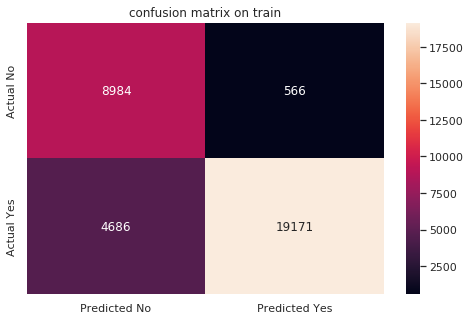

best test threshold : 0.7937209160002897


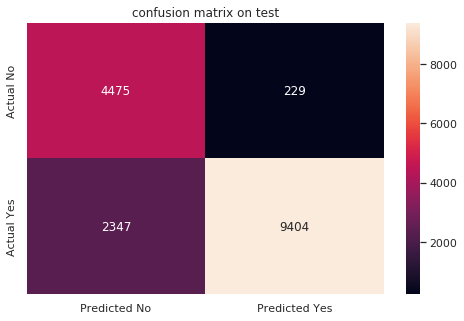

None


In [165]:
print(plot_confusion_matrix(lr_tuned,X_train,X_test,Y_train,Y_test))

In [166]:
## checking confusion matrix value with threshold 0.5 and with best threshold wuth roc_curve
## we need high recall, so false negative ( actual fraud but predicted as non fraud ) is less
## so here true positive increase and false negative decrease 

## true positive in train with threshold 0.5 - 94705
## true positive in train with best threshold -  99988

## false negative in train with threshold 0.5 - 47868
## false negative in train with best threshold -  42585


y_train_pred = lr_tuned.predict(X_train)
y_test_pred = lr_tuned.predict(X_test)

train_conf_matrix = confusion_matrix(Y_train, y_train_pred)
test_conf_matrix = confusion_matrix(Y_test, y_test_pred)
print('train confusion matrix without best threshold:\n',train_conf_matrix)
print('test confusion matrix without best threshold:\n',test_conf_matrix)

## fpr,tpr,threshold
y_train_pred = lr_tuned.predict_proba(X_train)
y_train_pred = y_train_pred[:, 1]

y_test_pred = lr_tuned.predict_proba(X_test)
y_test_pred = y_test_pred[:, 1]


train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#tn, fp, fn, tp

## train
best_tr_threshold = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print('best train threshold :',best_tr_threshold)
train_conmat = confusion_matrix(Y_train, predict_using_best_threshold(y_train_pred, best_tr_threshold))

## test
best_te_threshold = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print('best test threshold :',best_te_threshold)
test_conmat = confusion_matrix(Y_test, predict_using_best_threshold(y_test_pred, best_te_threshold))


print('train confusion matrix with best threshold:\n',train_conmat)
print('train confusion matrix with best threshold:\n',test_conmat)

train confusion matrix without best threshold:
 [[ 7240  2310]
 [ 2202 21655]]
test confusion matrix without best threshold:
 [[ 3562  1142]
 [ 1061 10690]]
best train threshold : 0.7841772074947412
best test threshold : 0.7937209160002897
train confusion matrix with best threshold:
 [[ 8984   566]
 [ 4686 19171]]
train confusion matrix with best threshold:
 [[4475  229]
 [2347 9404]]


In [167]:
## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(lr_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

Train F1 score is : 0.8795247052346653
Test F1 score is : 0.879536101758324
Train macro F1 score is : 0.8266701906879614
Test macro F1 score is : 0.8280206970703818


In [168]:
import joblib
joblib.dump(lr_tuned, 'lr_tuned_on_0.pkl')

['lr_tuned_on_0.pkl']

In [169]:
lr_tuned = joblib.load('lr_tuned_on_0.pkl')

In [170]:
table = PrettyTable(['feature','weight'])   

feature = X.columns
feature_importances = lr_tuned.coef_
indices = (np.argsort(feature_importances)).tolist()
print('important features :')
for i in indices[0]:
    table.add_row([feature[i],np.round(feature_importances[0][i],5)])
print(table)    


important features :
+---------------------------------+----------+
|             feature             |  weight  |
+---------------------------------+----------+
|            benecount            | -0.19345 |
|     DiagnosisGroupCode_count    | -0.13269 |
|      DiagnosisCode_7_count      | -0.11692 |
|      DiagnosisCode_6_count      | -0.11586 |
|      DiagnosisCode_8_count      | -0.11574 |
|      DiagnosisCode_9_count      | -0.11405 |
|      DiagnosisCode_5_count      | -0.10934 |
|   ClmAdmitDiagnosisCode_count   | -0.10286 |
|      DiagnosisCode_10_count     | -0.10026 |
|      DiagnosisCode_4_count      | -0.09663 |
|      DiagnosisCode_3_count      | -0.07786 |
|    ChronicCond_IschemicHeart    | -0.06824 |
|       ChronicCond_Diabetes      | -0.06249 |
|      DiagnosisCode_2_count      | -0.04985 |
|     ChronicCond_Heartfailure    | -0.04947 |
|              State              | -0.04907 |
|      ChronicCond_Depression     | -0.03979 |
|      ChronicCond_Alzheimer      | -0.

### 6.1.2. model with null filled with mode

In [171]:
print('best parameter :',lr_tune.best_params_)
print("accuracy on train :",lr_tune.best_score_)

best parameter : {'penalty': 'l1', 'C': 1000}
accuracy on train : 0.8912503367557697


In [172]:
## on best parameter

lr_tuned = LogisticRegression(C=0.01,penalty='l2')
lr_tuned.fit(X_train,Y_train)
print('accuracy on test :',lr_tuned.score(X_test,Y_test))

accuracy on test : 0.8661804922515952


In [173]:
lr_tuned = joblib.load('lr_tuned_on_0.pkl')

best train threshold : 0.7841772074947412


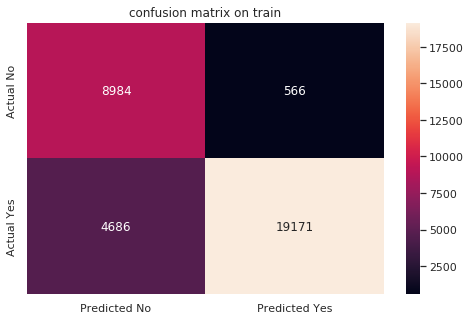

best test threshold : 0.7937209160002897


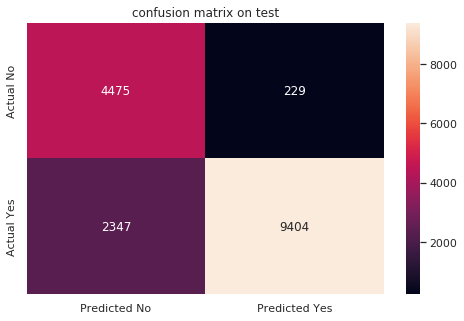

None


In [174]:
print(plot_confusion_matrix(lr_tuned,X_train,X_test,Y_train,Y_test))

In [175]:
## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(lr_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

Train F1 score is : 0.8795247052346653
Test F1 score is : 0.879536101758324
Train macro F1 score is : 0.8266701906879614
Test macro F1 score is : 0.8280206970703818


In [176]:
joblib.dump(lr_tuned, 'lr_tuned_on_mode.pkl')

['lr_tuned_on_mode.pkl']

In [177]:
table = PrettyTable(['feature','weight'])   

feature = X.columns
feature_importances = lr_tuned.coef_
indices = (np.argsort(feature_importances)).tolist()
print('important features :')
for i in indices[0]:
    table.add_row([feature[i],np.round(feature_importances[0][i],5)])
print(table)    


important features :
+---------------------------------+----------+
|             feature             |  weight  |
+---------------------------------+----------+
|            benecount            | -0.19345 |
|     DiagnosisGroupCode_count    | -0.13269 |
|      DiagnosisCode_7_count      | -0.11692 |
|      DiagnosisCode_6_count      | -0.11586 |
|      DiagnosisCode_8_count      | -0.11574 |
|      DiagnosisCode_9_count      | -0.11405 |
|      DiagnosisCode_5_count      | -0.10934 |
|   ClmAdmitDiagnosisCode_count   | -0.10286 |
|      DiagnosisCode_10_count     | -0.10026 |
|      DiagnosisCode_4_count      | -0.09663 |
|      DiagnosisCode_3_count      | -0.07786 |
|    ChronicCond_IschemicHeart    | -0.06824 |
|       ChronicCond_Diabetes      | -0.06249 |
|      DiagnosisCode_2_count      | -0.04985 |
|     ChronicCond_Heartfailure    | -0.04947 |
|              State              | -0.04907 |
|      ChronicCond_Depression     | -0.03979 |
|      ChronicCond_Alzheimer      | -0.

## 6.2. DecisionTreeClassifier 

In [178]:
dt = DecisionTreeClassifier(class_weight='balanced')
param = {'max_depth': [5,10,50,100,250,500,1000],
         'min_samples_split': [5,10,50,100,200,300,400],
         'criterion': ['gini','entropy']}

dt_tune = RandomizedSearchCV(dt,param,cv=10,n_jobs=-1,verbose=1)
dt_tune.fit(X_train,Y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.4s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter=

## 6.2.1. model with null filled with 0

In [179]:
print('best parameter :',dt_tune.best_params_)
print("accuracy on train :",dt_tune.best_score_)

best parameter : {'min_samples_split': 5, 'max_depth': 250, 'criterion': 'gini'}
accuracy on train : 0.9985033076900051


In [180]:
## on best parameter

dt_tuned = DecisionTreeClassifier(max_depth=50,min_samples_split=10,criterion='gini')
dt_tuned.fit(X_train,Y_train)
print('accuracy on test :',dt_tuned.score(X_test,Y_test))

accuracy on test : 0.9987845639623215


In [181]:
import joblib
joblib.dump(dt_tuned, 'dt_tuned_on_0.pkl')

['dt_tuned_on_0.pkl']

In [182]:
dt_tuned = joblib.load('dt_tuned_on_0.pkl')

best train threshold : 1.0


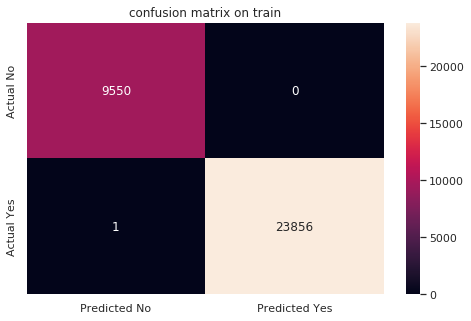

best test threshold : 1.0


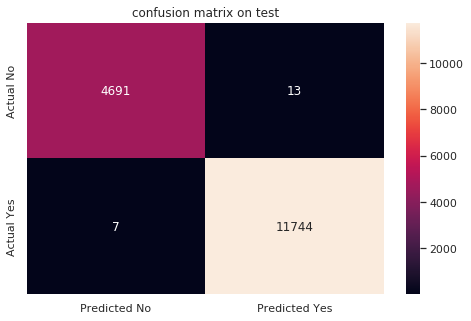

None


In [183]:
print(plot_confusion_matrix(dt_tuned,X_train,X_test,Y_train,Y_test))

In [184]:
## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(dt_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

Train F1 score is : 0.9999790413514137
Test F1 score is : 0.9991492257954739
Train macro F1 score is : 0.9999633440357403
Test macro F1 score is : 0.9985110094091175


In [185]:
joblib.dump(dt_tuned, 'dt_tuned_on_0.pkl')

['dt_tuned_on_0.pkl']

In [186]:
print(important_feature(dt_tuned,X))

important features :
+--------------------------+---------+
|         feature          |  weight |
+--------------------------+---------+
|         procount         | 0.66536 |
|          index           | 0.12869 |
|      ProviderCount       | 0.05822 |
| DiagnosisGroupCode_count | 0.05559 |
|          County          | 0.04498 |
|         phycount         | 0.02118 |
| AttendingPhysicianCount  | 0.01874 |
|          State           | 0.00678 |
|      num_of_chronic      | 0.00017 |
| OPAnnualReimbursementAmt | 0.00015 |
|        BeneCount         | 0.00013 |
|  InscClaimAmtReimbursed  |  1e-05  |
|     diagnosis_25000      |   0.0   |
|  RenalDiseaseIndicator   |   0.0   |
|    ChronicCond_stroke    |   0.0   |
|        benecount         |   0.0   |
|  DiagnosisCode_10_count  |   0.0   |
|    DeductibleAmtPaid     |   0.0   |
|  OPAnnualDeductibleAmt   |   0.0   |
|          Gender          |   0.0   |
+--------------------------+---------+


## 6.2.2. model with null filled with mode

In [187]:
print('best parameter :',dt_tune.best_params_)
print("accuracy on train :",dt_tune.best_score_)

best parameter : {'min_samples_split': 5, 'max_depth': 250, 'criterion': 'gini'}
accuracy on train : 0.9985033076900051


In [188]:
## on best parameter

dt_tuned = DecisionTreeClassifier(max_depth= 50,min_samples_split= 5,criterion= 'entropy')
dt_tuned.fit(X_train,Y_train)
print('accuracy on test :',dt_tuned.score(X_test,Y_test))

accuracy on test : 0.9998176845943483


best train threshold : 1.0


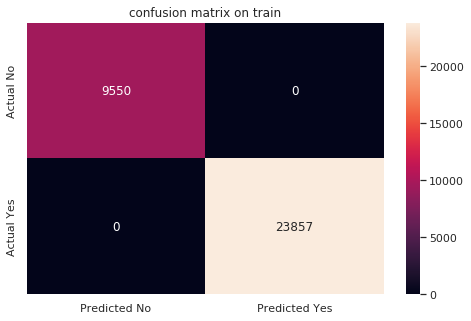

best test threshold : 1.0


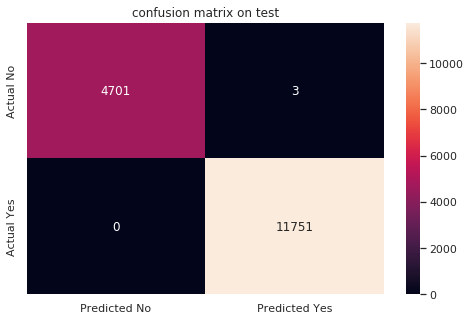

None


In [189]:
## confusion matrix 

print(plot_confusion_matrix(dt_tuned,X_train,X_test,Y_train,Y_test))

In [190]:
joblib.dump(dt_tuned, 'dt_tuned_on_mode.pkl')

['dt_tuned_on_mode.pkl']

In [191]:
## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(dt_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

## important features

print(important_feature(dt_tuned,X))

Train F1 score is : 1.0
Test F1 score is : 0.9998723675813657
Train macro F1 score is : 1.0
Test macro F1 score is : 0.999776694157509
important features :
+--------------------------+---------+
|         feature          |  weight |
+--------------------------+---------+
|         procount         | 0.67782 |
|          index           | 0.14262 |
|         phycount         | 0.05639 |
|      ProviderCount       | 0.05327 |
| DiagnosisGroupCode_count | 0.04307 |
| AttendingPhysicianCount  | 0.01326 |
|          State           |  0.0125 |
|          County          |  0.0008 |
|      num_of_chronic      | 0.00016 |
|        BeneCount         | 0.00013 |
|           Race           |   0.0   |
|  RenalDiseaseIndicator   |   0.0   |
|        benecount         |   0.0   |
|  DiagnosisCode_9_count   |   0.0   |
|  DiagnosisCode_10_count  |   0.0   |
|  InscClaimAmtReimbursed  |   0.0   |
|  OPAnnualDeductibleAmt   |   0.0   |
| OPAnnualReimbursementAmt |   0.0   |
|  IPAnnualDeductibleAmt 

## 6.3. RandomForestClassifier 

In [192]:
rf = RandomForestClassifier(class_weight='balanced')
param = { 'n_estimators': [10,50,100,500,1000], 'max_depth' : [2,4,6,8,10,12],'min_samples_split': [5,10,50,100,200,250],'criterion' :['gini', 'entropy']}

rf_tune = RandomizedSearchCV(rf,param,cv=5,n_jobs=-1,verbose=1)
rf_tune.fit(X_train, Y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

## 6.3.1. model with null filled with 0

In [193]:
print('best parameter :',rf_tune.best_params_)
print("accuracy on train :",rf_tune.best_score_)

best parameter : {'n_estimators': 100, 'min_samples_split': 50, 'max_depth': 12, 'criterion': 'entropy'}
accuracy on train : 0.9692579399527045


In [194]:
## on best parameter

rf_tuned = RandomForestClassifier(max_depth=12,min_samples_split=10,criterion='entropy',n_estimators=50,n_jobs=-1)
rf_tuned.fit(X_train,Y_train)
print('accuracy on test :',rf_tuned.score(X_test,Y_test))

accuracy on test : 0.9817684594348223


best train threshold : 0.3411721853632646


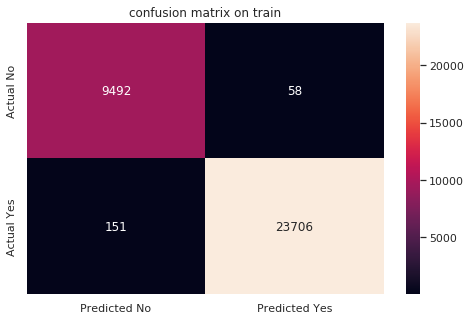

best test threshold : 0.4507037489771835


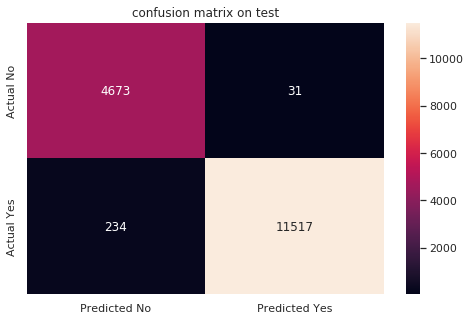

None


In [195]:
print(plot_confusion_matrix(rf_tuned,X_train,X_test,Y_train,Y_test))

In [196]:
f1_train,f1_test,macro_f1_train,macro_f1_test = f1(rf_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

Train F1 score is : 0.9956111799416224
Test F1 score is : 0.9886261212927593
Train macro F1 score is : 0.9923608965930172
Test macro F1 score is : 0.9805267740997143


In [197]:
joblib.dump(rf_tuned, 'rf_tuned_on_0.pkl')

['rf_tuned_on_0.pkl']

In [198]:
print(important_feature(rf_tuned,X))

important features :
+--------------------------+---------+
|         feature          |  weight |
+--------------------------+---------+
|         procount         | 0.34934 |
|      ProviderCount       | 0.33607 |
|          index           | 0.08109 |
|         phycount         | 0.05003 |
| AttendingPhysicianCount  | 0.04822 |
|          County          | 0.04334 |
|          State           |  0.0337 |
| DiagnosisGroupCode_count | 0.00896 |
|  InscClaimAmtReimbursed  | 0.00511 |
|    DeductibleAmtPaid     | 0.00504 |
|        BeneCount         | 0.00355 |
|    numOfDaysAdmitted     | 0.00349 |
|     num_of_diag_proc     | 0.00313 |
|        benecount         | 0.00264 |
|  DiagnosisCode_9_count   | 0.00201 |
|    ip_op_total_amount    | 0.00198 |
|  DiagnosisCode_6_count   | 0.00181 |
| OPAnnualReimbursementAmt |  0.0016 |
|  OPAnnualDeductibleAmt   | 0.00156 |
|  DiagnosisCode_7_count   | 0.00152 |
+--------------------------+---------+


## 6.3.2. model with null filled with mode

In [199]:
print('best parameter :',rf_tune.best_params_)
print("accuracy on train :",rf_tune.best_score_)

best parameter : {'n_estimators': 100, 'min_samples_split': 50, 'max_depth': 12, 'criterion': 'entropy'}
accuracy on train : 0.9692579399527045


In [200]:
## on best parameter

rf_tuned = RandomForestClassifier(max_depth=10,min_samples_split=5,criterion='gini',n_estimators=500,n_jobs=-1)
rf_tuned.fit(X_train,Y_train)
print('accuracy on test :',rf_tuned.score(X_test,Y_test))

accuracy on test : 0.9787906411425099


best train threshold : 0.33857165053074467


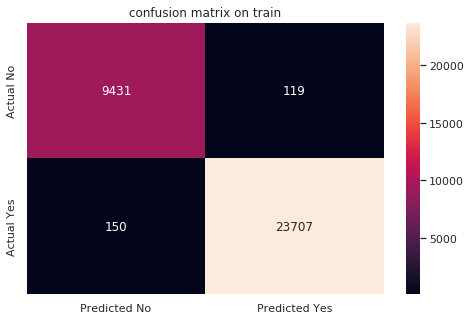

best test threshold : 0.3520623635416237


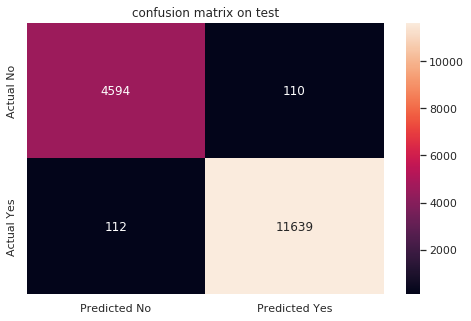

None


In [201]:
print(plot_confusion_matrix(rf_tuned,X_train,X_test,Y_train,Y_test))

In [202]:
joblib.dump(rf_tuned, 'rf_tuned_on_mode.pkl')

['rf_tuned_on_mode.pkl']

In [203]:
f1_train,f1_test,macro_f1_train,macro_f1_test = f1(rf_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

print(important_feature(rf_tuned,X))

Train F1 score is : 0.994358576431852
Test F1 score is : 0.9905531914893617
Train macro F1 score is : 0.9901488141162971
Test macro F1 score is : 0.983480634001854
important features :
+-----------------------------+---------+
|           feature           |  weight |
+-----------------------------+---------+
|           procount          | 0.33951 |
|        ProviderCount        | 0.33172 |
|            index            | 0.08245 |
|            County           | 0.05845 |
|           phycount          | 0.04591 |
|   AttendingPhysicianCount   |  0.0419 |
|            State            | 0.03782 |
|   DiagnosisGroupCode_count  | 0.00732 |
|      numOfDaysAdmitted      | 0.00712 |
|      DeductibleAmtPaid      | 0.00687 |
|    InscClaimAmtReimbursed   | 0.00634 |
|       num_of_diag_proc      | 0.00387 |
|          benecount          | 0.00271 |
|          BeneCount          | 0.00264 |
|      ip_op_total_amount     | 0.00169 |
|    DiagnosisCode_7_count    | 0.00163 |
|    DiagnosisCod

## 6.4. XGBClassifier 

In [ ]:
xgb = XGBClassifier()
param = {'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],'n_estimators':[100,200,500,1000],'max_depth':[3,5,10],'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1] } 

xgb_tune = RandomizedSearchCV(xgb,param,cv=5,n_jobs=-1,verbose=10)

xgb_tune.fit(X_train,Y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5, score=0.991, total=   6.6s
[CV] subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5, score=0.986, total=   6.5s
[CV] subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV]  subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5, score=0.989, total=   7.2s
[CV] subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s


[CV]  subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5, score=0.988, total=   6.3s
[CV] subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.6s remaining:    0.0s


[CV]  subsample=1, n_estimators=100, max_depth=5, learning_rate=0.03, colsample_bytree=0.5, score=0.994, total=   6.4s
[CV] subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.0s remaining:    0.0s


[CV]  subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1, score=1.000, total=  53.5s
[CV] subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1, score=1.000, total=  52.9s
[CV] subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.3min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1, score=1.000, total=  53.9s
[CV] subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.2min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1, score=1.000, total=  52.8s
[CV] subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.1min remaining:    0.0s


[CV]  subsample=0.5, n_estimators=500, max_depth=10, learning_rate=0.1, colsample_bytree=1, score=1.000, total=  53.9s
[CV] subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1, score=0.947, total=   6.6s
[CV] subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1, score=0.955, total=   6.6s
[CV] subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1, score=0.928, total=   6.7s
[CV] subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1 
[CV]  subsample=0.3, n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=0.1, score=0.924, total=   6.6s
[CV] subsample=0.3, n_est

## 6.4.1. model with null filled with 0

In [ ]:
print('best parameter :',xgb_tune.best_params_)
print("accuracy on train :",xgb_tune.best_score_)

In [ ]:
## on best parameter

xgb_tuned = XGBClassifier(subsample=0.5,n_estimators= 1000,max_depth= 10,colsample_bytree=0.5,learning_rate= 0.2,n_jobs=-1)
xgb_tuned.fit(X_train,Y_train)
print('accuracy on test :',xgb_tuned.score(X_test,Y_test))

In [ ]:
xgb_tuned = joblib.load('xgb_tuned_on_0.pkl')

In [ ]:
print(plot_confusion_matrix(xgb_tuned,X_train,X_test,Y_train,Y_test))

In [ ]:
joblib.dump(xgb_tuned, 'xgb_tuned_on_0.pkl')

In [ ]:
## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(xgb_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

print(important_feature(xgb_tuned,X))

## 6.4.2. model with null filled with mode

In [ ]:
print('best parameter :',xgb_tune.best_params_)
print("accuracy on train :",xgb_tune.best_score_)

In [ ]:
## on best parameter

xgb_tuned = XGBClassifier(subsample=0.3,n_estimators= 1000,max_depth= 10,colsample_bytree=0.5,learning_rate= 0.2,n_jobs=-1)
xgb_tuned.fit(X_train,Y_train)
print('accuracy on test :',xgb_tuned.score(X_test,Y_test))


In [ ]:
print(plot_confusion_matrix(xgb_tuned,X_train,X_test,Y_train,Y_test))

In [ ]:
joblib.dump(xgb_tuned, 'xgb_tuned_on_mode.pkl')

In [ ]:
f1_train,f1_test,macro_f1_train,macro_f1_test = f1(xgb_tuned,X_train,X_test,Y_train,Y_test)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

print(important_feature(xgb_tuned,X))

## Custom Ensemble model

### procedure followed
    1. split data into 80:20 train,test
    2. split train into D1, D2 50:50
    3. do sampling with replacement on D1 and take k samples
    4. train k model on this k sample ( DT as base model )
    5. use D2 and pass it to this k model and get k prediction
    6. here we have actual y of D2 (from step 2) and target of D2 (from step 5)
    7. train meta model with data of step 6
    8. for evaluation take test data (from step 1)
    9. take test and predict on k model (step 4) and get k prediction
    10. here we have actual y of test (from step 1) and target of test (from step 9)
    11. as performance evaluation, train on (pred_for_D2,D2Y) and fit on (pred_for_test,test_Y)

    num of base model trained is 30,45,40. 40 seem to have good accuracy

### different meta model trained:
    1.LR
    2.DT
    3.RF
    4.xgb

In [ ]:
## file with null filled with 0

final_data = pd.read_csv('final_data_feature.csv')
final_data.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
## split data into 80:20

from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.20,random_state=0)


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

def min_max(D1,D2,test,column):
    """ scaling column value using min max scalar, fitting on train and transforming """
    
    min_max_scaler.fit(D1[column].values.reshape(-1,1))
    
    d1_scale = min_max_scaler.transform(D1[column].values.reshape(-1,1))
    d2_scale = min_max_scaler.transform(D2[column].values.reshape(-1,1))
    test_scale = min_max_scaler.transform(test[column].values.reshape(-1,1))
    
    return d1_scale,d2_scale,test_scale


In [ ]:
import random
def generating_samples(input_data, target_data):
    """ row and col sampling with replacement """
    
    ## selecting 60 % row from input data
    selecting_rows = np.sort(np.random.choice(input_data.shape[0],size=int((60/100)*input_data.shape[0]),replace=False))
    
    ## selecting 3 - 58 col from input data
    selecting_colums = np.sort(np.random.choice(input_data.shape[1],size=random.randint(3,input_data.shape[1]),replace =False))
    
    ## sampling row from input
    sample_data = input_data[selecting_rows[:,None],selecting_colums]
    
    ## sampling target row from input
    target_of_sample_data = target_data[selecting_rows]
    
    ## replicating from sample data
    replacing_rows =np.sort(np.random.choice(selecting_rows,size=int(input_data.shape[0]*0.4),replace=False))
    
    ## re sampling row from sample data
    replicated_sample_data = input_data[replacing_rows[:, None], selecting_colums]
    
    ## re sampling target row from sample data
    target_of_replicated_sample_data = target_data[replacing_rows]

    final_sample_data = np.vstack((sample_data, replicated_sample_data))
    final_target_data = np.vstack((target_of_sample_data.reshape(-1,1),target_of_replicated_sample_data.reshape(-1,1)))
    
    return final_sample_data,final_target_data,selecting_rows,selecting_colums


In [ ]:
def custom_ensemble(train, test, n_estimators): 
    """ take train, test, num of base model and divide train into D1,D2 , 
    train base model with D1, predict on D2, take test and predict using base model"""
    
    ## split train into D1,D2
    D1,D2 = train_test_split(train, test_size=0.50,random_state=0)
    
    
    ## col to normalize
    col_to_nor = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Race',
       'State', 'County', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BeneCount',
       'ProviderCount', 'AttendingPhysicianCount', 'numOfDaysAdmitted',
       'numOfDaysForClaim', 'ip_op_total_amount', 'num_of_chronic',
       'num_of_diag_proc', 'num_of_phy', 'DiagnosisCode_1_count', 'DiagnosisCode_2_count',
       'DiagnosisCode_3_count', 'DiagnosisCode_4_count',
       'DiagnosisCode_5_count', 'DiagnosisCode_6_count',
       'DiagnosisCode_7_count', 'DiagnosisCode_8_count',
       'DiagnosisCode_9_count', 'DiagnosisCode_10_count',
       'ClmAdmitDiagnosisCode_count', 'DiagnosisGroupCode_count']

    for i in col_to_nor:
        d1_scale,d2_scale,test_scale = min_max(D1,D2,test,i)

        D1[i] = d1_scale
        D2[i] = d2_scale
        test[i] = test_scale
    print('nomalizing done...')
    
    
    ## split D1 to x,y
    Y = D1['PotentialFraud'].values
    X = D1.drop('PotentialFraud',axis=1).values
    
    
    ## generating n_estimators sample 
    list_input_data =[]
    list_output_data =[]
    list_selected_row= []
    list_selected_columns=[] 

    for i in range(0,n_estimators):
        data,target,selecting_rows,selecting_columns = generating_samples(X,Y)
        list_input_data.append(data)
        list_output_data.append(target)
        list_selected_row.append(selecting_rows)
        list_selected_columns.append(selecting_columns)
        

    ## train n_estimators model on this n_estimators sample
    ## using best param from Dt trained with null filled with 0
    list_of_all_models = []
    for i in range(0, n_estimators):
        input_data = list_input_data[i]
        target_data = list_output_data[i]
        classifier = DecisionTreeClassifier(class_weight='balanced',max_depth=50,min_samples_split=10,criterion='gini',random_state=0)
        classifier.fit(input_data,target_data)
        list_of_all_models.append(classifier)
    print(n_estimators,'base model trained...')
    
    
    ## split D1 to x,y
    D2Y = D2['PotentialFraud'].values
    D2X=  D2.drop('PotentialFraud', axis=1).values
    
    
    ## passing the D2 set to each of these n_estimators models, and getting n_estimators set of predictions for D2, from each of these models
    pred_for_D2 = []
    for i in range(0,n_estimators):
        pred_y = list_of_all_models[i].predict(D2X[:,list_selected_columns[i]])
        pred_for_D2.append(pred_y)


    ## shape of prediction on D2 is (30, ), so transpose to get ( ,30)
    pred_for_D2 = np.array(pred_for_D2).transpose()

    
    ## fitting LR on : prediction of D2 as X, and actual D2Y as Y

    param = { 'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty' : ['l1','l2'] }
    lr = LogisticRegression()
    lr_tune = RandomizedSearchCV(lr,param,cv=10,n_jobs=-1)
    lr_tune.fit(pred_for_D2,D2Y)
    
    print('best parameter :',lr_tune.best_params_)
    print("accuracy on train :",lr_tune.best_score_)

    
    ## getting prediction on test using base models
    
    test_Y = test['PotentialFraud'].values
    test_X=  test.drop('PotentialFraud', axis=1).values
    
    pred_for_test = []
    for i in range(0,n_estimators):
        pred_y = list_of_all_models[i].predict(test_X[:,list_selected_columns[i]])
        pred_for_test.append(pred_y)

    pred_for_test = np.array(pred_for_test).transpose()
    print('prediction on test done...')

    return pred_for_test,pred_for_D2,D2Y,test_Y

## with 30 base model

In [ ]:
## return D2 actual y, pred on D2, actual y test, pred on y test

pred_for_test,pred_for_D2,D2Y,test_Y = custom_ensemble(train, test, 30)

In [ ]:
## fitting LR on : prediction of D2 as X, and actual D2Y as Y
## testing on : prediction on test using base models as X, and actual test_Y as Y

lr_tuned = LogisticRegression(C=100,penalty='l1')
lr_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',lr_tuned.score(pred_for_test,test_Y))

## with 45 base model

In [ ]:
pred_for_test,pred_for_D2,D2Y,test_Y = custom_ensemble(train, test, 45)

In [ ]:
## fitting LR on : prediction of D2 as X, and actual D2Y as Y
## testing on : prediction on test using base models as X, and actual test_Y as Y

lr_tuned = LogisticRegression(C=1000,penalty='l1')
lr_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',lr_tuned.score(pred_for_test,test_Y))

## with 40 base model

In [ ]:
pred_for_test,pred_for_D2,D2Y,test_Y = custom_ensemble(train, test, 40)

In [ ]:
## fitting LR on : prediction of D2 as X, and actual D2Y as Y
## testing on : prediction on test using base models as X, and actual test_Y as Y

lr_tuned = LogisticRegression(C=0.1,penalty='l2')
lr_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',lr_tuned.score(pred_for_test,test_Y))

### accuracy on base model
    accuracy on base model 30 : 0.982739625413
    accuracy on base model 45 : 0.984342950297
    accuracy on base model 40 : 0.983393495338
### conclusion
    accuracy doesnt increase much, so number of base model selected 40

## LR as metamodel with 40 base model

In [ ]:
param = { 'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty' : ['l1','l2'] }
lr = LogisticRegression()
lr_tune = RandomizedSearchCV(lr,param,cv=10,n_jobs=-1)
lr_tune.fit(pred_for_D2,D2Y)
    
print('best parameter :',lr_tune.best_params_)
print("accuracy on train :",lr_tune.best_score_)

In [ ]:
lr_tuned = LogisticRegression(C=1,penalty='l2')
lr_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',lr_tuned.score(pred_for_test,test_Y))

In [ ]:
joblib.dump(lr_tuned, 'ensem_lr_tuned_on_0.pkl')

In [ ]:
lr_tuned = joblib.load('ensem_lr_tuned_on_0.pkl')

In [ ]:
print(plot_confusion_matrix(lr_tuned,pred_for_D2,pred_for_test,D2Y,test_Y))

## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(lr_tuned,pred_for_D2,pred_for_test,D2Y,test_Y)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

## Decision Tree metamodel

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')
param = {'max_depth': [5,10,50,100,250,500,1000],
         'min_samples_split': [5,10,50,100,200,300,400],
         'criterion': ['gini','entropy']}

dt_tune = RandomizedSearchCV(dt,param,cv=10,n_jobs=-1,verbose=1)
dt_tune.fit(pred_for_D2,D2Y)

print('best parameter :',dt_tune.best_params_)
print("accuracy on train :",dt_tune.best_score_)

In [ ]:
dt_tuned = DecisionTreeClassifier(max_depth= 250,criterion= 'gini',min_samples_split= 100)
dt_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',dt_tuned.score(pred_for_test,test_Y))

In [ ]:
joblib.dump(dt_tuned, 'ensem_dt_tuned_on_0.pkl')

In [ ]:
dt_tuned = joblib.load('ensem_dt_tuned_on_0.pkl')

In [ ]:
print(plot_confusion_matrix(dt_tuned,pred_for_D2,pred_for_test,D2Y,test_Y))

## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(dt_tuned,pred_for_D2,pred_for_test,D2Y,test_Y)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

## Random Forest metamodel 

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
param = { 'n_estimators': [10,50,100,500,1000], 'max_depth' : [2,4,6,8,10,12],'min_samples_split': [5,10,50,100,200,250],'criterion' :['gini', 'entropy']}

rf_tune = RandomizedSearchCV(rf,param,cv=5,n_jobs=-1,verbose=1)
rf_tune.fit(pred_for_D2,D2Y)

print('best parameter :',rf_tune.best_params_)
print("accuracy on train :",rf_tune.best_score_)

In [ ]:
rf_tuned = RandomForestClassifier(max_depth= 6,criterion= 'entropy',min_samples_split= 5,n_estimators= 1000)
rf_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',rf_tuned.score(pred_for_test,test_Y))

In [ ]:
joblib.dump(rf_tuned, 'ensem_rf_tuned_on_0.pkl')

In [ ]:
rf_tuned = joblib.load('ensem_rf_tuned_on_0.pkl')

In [ ]:
print(plot_confusion_matrix(rf_tuned,pred_for_D2,pred_for_test,D2Y,test_Y))

## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(rf_tuned,pred_for_D2,pred_for_test,D2Y,test_Y)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

## XGB metamodel

In [ ]:
xgb = XGBClassifier()
param = {'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],'n_estimators':[100,200,500,1000],'max_depth':[3,5,10],'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1] } 

xgb_tune = RandomizedSearchCV(xgb,param,cv=5,n_jobs=-1,verbose=10)

xgb_tune.fit(pred_for_D2,D2Y)

print('best parameter :',xgb_tune.best_params_)
print("accuracy on train :",xgb_tune.best_score_)

In [ ]:
xgb_tuned = XGBClassifier(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=1,subsample=0.5)
xgb_tuned.fit(pred_for_D2,D2Y)
print('accuracy on test :',xgb_tuned.score(pred_for_test,test_Y))

In [ ]:
joblib.dump(xgb_tuned, 'ensem_xgb_tuned_on_0.pkl')

In [ ]:
xgb_tuned = joblib.load('ensem_xgb_tuned_on_0.pkl')

In [ ]:
print(plot_confusion_matrix(xgb_tuned,pred_for_D2,pred_for_test,D2Y,test_Y))

## f1 score

f1_train,f1_test,macro_f1_train,macro_f1_test = f1(xgb_tuned,pred_for_D2,pred_for_test,D2Y,test_Y)
print('Train F1 score is :',f1_train)
print('Test F1 score is :',f1_test)
print('Train macro F1 score is :',macro_f1_train)
print('Test macro F1 score is :',macro_f1_test)

## conclusion
1. model with null filled with 0
       xgb, DT have better performance 
2. model with null filled with mode
       no much increase in performance in all model
3. custom ensemble model with null filled with 0
       LR,DT,RF,xgb all metamodel perform good and same.
#### overall performance of xgb is better than all other model

## summary

made two models on data:
    1. using null value filled with 0
    2. using null value filled with mode
    3. custom ensemble model with null value filled with 0
 column that are performed with imputation are -----
 [ 'ClmDiagnosisCode_1','ClmDiagnosisCode_2',
             'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
             'ClmDiagnosisCode_5','ClmDiagnosisCode_6',
             'ClmDiagnosisCode_7','ClmDiagnosisCode_8',
             'ClmDiagnosisCode_9','ClmDiagnosisCode_10',
             'ClmProcedureCode_1','ClmProcedureCode_2',
             'ClmProcedureCode_3','ClmProcedureCode_4',
             'DiagnosisGroupCode','ClmAdmitDiagnosisCode',
             AttendingPhysicianCount, num_of_phy, DeductibleAmtPaid ]

 mean ( mode is 0 ) - [ numOfDaysAdmitted, numOfDaysForClaim ] 

1. train test split
   test size = 0.33

2. feature scaling done with min max scalar on ----- [ 'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Race',
   'State', 'County', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
   'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BeneCount',
   'ProviderCount', 'AttendingPhysicianCount', 'numOfDaysAdmitted',
      'numOfDaysForClaim', 'ip_op_total_amount', 'num_of_chronic',
      'num_of_diag_proc', 'num_of_phy', 'DiagnosisCode_1_count', 'DiagnosisCode_2_count',
      'DiagnosisCode_3_count', 'DiagnosisCode_4_count',
      'DiagnosisCode_5_count', 'DiagnosisCode_6_count',
      'DiagnosisCode_7_count', 'DiagnosisCode_8_count',
      'DiagnosisCode_9_count', 'DiagnosisCode_10_count',
      'ClmAdmitDiagnosisCode_count', 'DiagnosisGroupCode_count' ]
    done separately on train and test to avoid data leak

3. model trained using missing value filled with 0
   1. LogisticRegression
   2. DecisionTreeClassifier
   3. RandomForestClassifier
   4. XGBClassifier
4. model trained using missing value filled with mode
   1. LogisticRegression
   2. DecisionTreeClassifier
   3. RandomForestClassifier
   4. XGBClassifier

5. hyperparameter tuning using random search
6. high presicion needed, so number of point which is actually fraud being predicted as non fraud decreases. best threshold is found using roc_curve and f1 score is build on this.

## model performance with null filled with 0
<table style="width:75%">
  <tr>
    <th>model</th>
    <th>accuracy</th>
    <th>f1 score</th>
    <th>macro f1 score</th>
  </tr>
  <tr>
    <td>LR</td>
    <td>0.822420064057</td>
    <td>0.743772804213</td>
    <td>0.799572764874</td>
  </tr>
  <tr>
    <td>DT</td>
    <td>0.976792790837</td>
    <td>0.969521107079</td>
    <td>0.975392086812</td>
  </tr>
  <tr>
    <td>RF</td>
    <td>0.847576135932</td>
    <td>0.799113218315</td>
    <td>0.840319340769</td>
  </tr>
  <tr>
    <td>xgb</td>
    <td>0.981797947994</td>
    <td>0.977490353008</td>
    <td>0.981851794151</td>
  </tr>
</table>

## model performance with null filled with mode
<table style="width:75%">
  <tr>
    <th>model</th>
    <th>accuracy</th>
    <th>f1 score</th>
    <th>macro f1 score</th>
  </tr>
  <tr>
    <td>LR</td>
    <td>0.83012865751</td>
    <td>0.739406238366</td>
    <td>0.792575792876</td>
  </tr>
  <tr>
    <td>DT</td>
    <td>0.980533087237</td>
    <td>0.974476505004</td>
    <td>0.979371526166</td>
  </tr>
  <tr>
    <td>RF</td>
    <td>0.847994137126</td>
    <td>0.788209669561</td>
    <td>0.829520481848</td>
  </tr>
  <tr>
    <td>xgb</td>
    <td>0.97632593236</td>
    <td>0.969402872909</td>
    <td>0.975355172118</td>
  </tr>
</table>

### conclusion
       1. model with null filled with 0
           xgb, DT have better performance 
       2. model with null filled with mode
           no much increase in performance in all model
       3. ensemble model with null filled with 0
           LR,DT,RF,xgb all metamodel perform good and same.
#### overall performance of xgb is better than all other model
       4. feature that help best predicting fraud in all model are - provider count, attending physician count, county, state, diagnosis code count
       
## custom ensemble model with null filled with 0
<table style="width:75%">
  <tr>
    <th>model</th>
    <th>accuracy</th>
    <th>f1 score</th>
    <th>macro f1 score</th>
  </tr>
 <tr>
    <td>LR</td>
    <td>0.982238026567</td>
    <td>0.976283152739</td>
    <td>0.98077598302</td>
  </tr>
  <tr>
    <td>DT</td>
    <td>0.980804887006</td>
    <td>0.974502923977</td>
    <td>0.979340643763</td>
  </tr>
  <tr>
    <td>RF</td>
    <td>0.981834956065</td>
    <td>0.976436970066</td>
    <td>0.980923237821</td>
  </tr>
  <tr>
    <td>xgb</td>
    <td>0.982202198078</td>
    <td>0.976239428064</td>
    <td>0.98073312755</td>
  </tr>
</table>
